<a href="https://colab.research.google.com/github/Oscarepg97/Estrategias-Trading/blob/master/SOL_USDT_Estrategia_diario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Estrategia tendencial long en **SOL/USDT** , apropiada para cualquier tipo de activo en temporalidad diaria.
- **Reglas de la estrategia**:

1.  Entra Long si el precio actual esta por encima del precio de cierre del mes pasado y
2.  RSI > 50

▶ Se cierra por stop loss o take proffit cuando el precio de hoy sea menor al precio de cierre del mes pasado (cierre del ultimo dia del mes anterior)

**- Que se muestra en este Colab?**

▶Resultados de la estrategia cambiando la gestion de riesgo por operacion, primero se muestra arriesgando un **porciento (%) del balance por operacion** , luego por **monto fijo de riesgo por operacion** y gestion utilizando la **Fraccion de Kelly (diluida )**

▶ Comparacion de cada estrategia en evolucion del balance de la cuenta y retornos mensuales y el historial operacion a operacion

# **Configuraciones iniciales**

In [19]:
!pip install ccxt matplotlib pandas backtesting pandas_ta mplfinance reportlab openpyxl


In [20]:
import os
import datetime
import ccxt
import pandas as pd
import pandas_ta as ta
import numpy as np
import time
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpdates
from datetime import timedelta

# **Ejecucion de estrategia por gestion de riesgo % del balance total**

**Configuración inicial de estrategia por gestion de riesgo % del balance total**

In [21]:
assets = ['SOL/USDT:USDT'] #Solo cambiar el nombre de la cryptomoneda antes del /
initial_balance = 1000 # Balance inicial de la cuenta
risk_percentage_value= 2 # Porcentaje de riesgo por operacion 2% por defecto(se puede cambiar al % que desees)
start_date = datetime.datetime(2021, 1, 1) # Fecha de inicio del backtest
end_date = datetime.datetime.now() # Fecha actual como Final del backtest


Analizando SOL/USDT:USDT

Estadísticas de Trading para SOL/USDT:USDT por riesgo % del balance total:
Balance Inicial: 1000  USDT
Balance Final: 5390.44 USDT
Retorno Total: 439.04%
Operaciones Totales: 40
Porcentaje de Aciertos: 35.00%

Métricas Detalladas:
Máximo Drawdown: 21.24%
Máxima operacion ganadora en $: $3436.51)

Promedios:
Ganancia promedio: $381.92 
Pérdida promedio: $-36.78


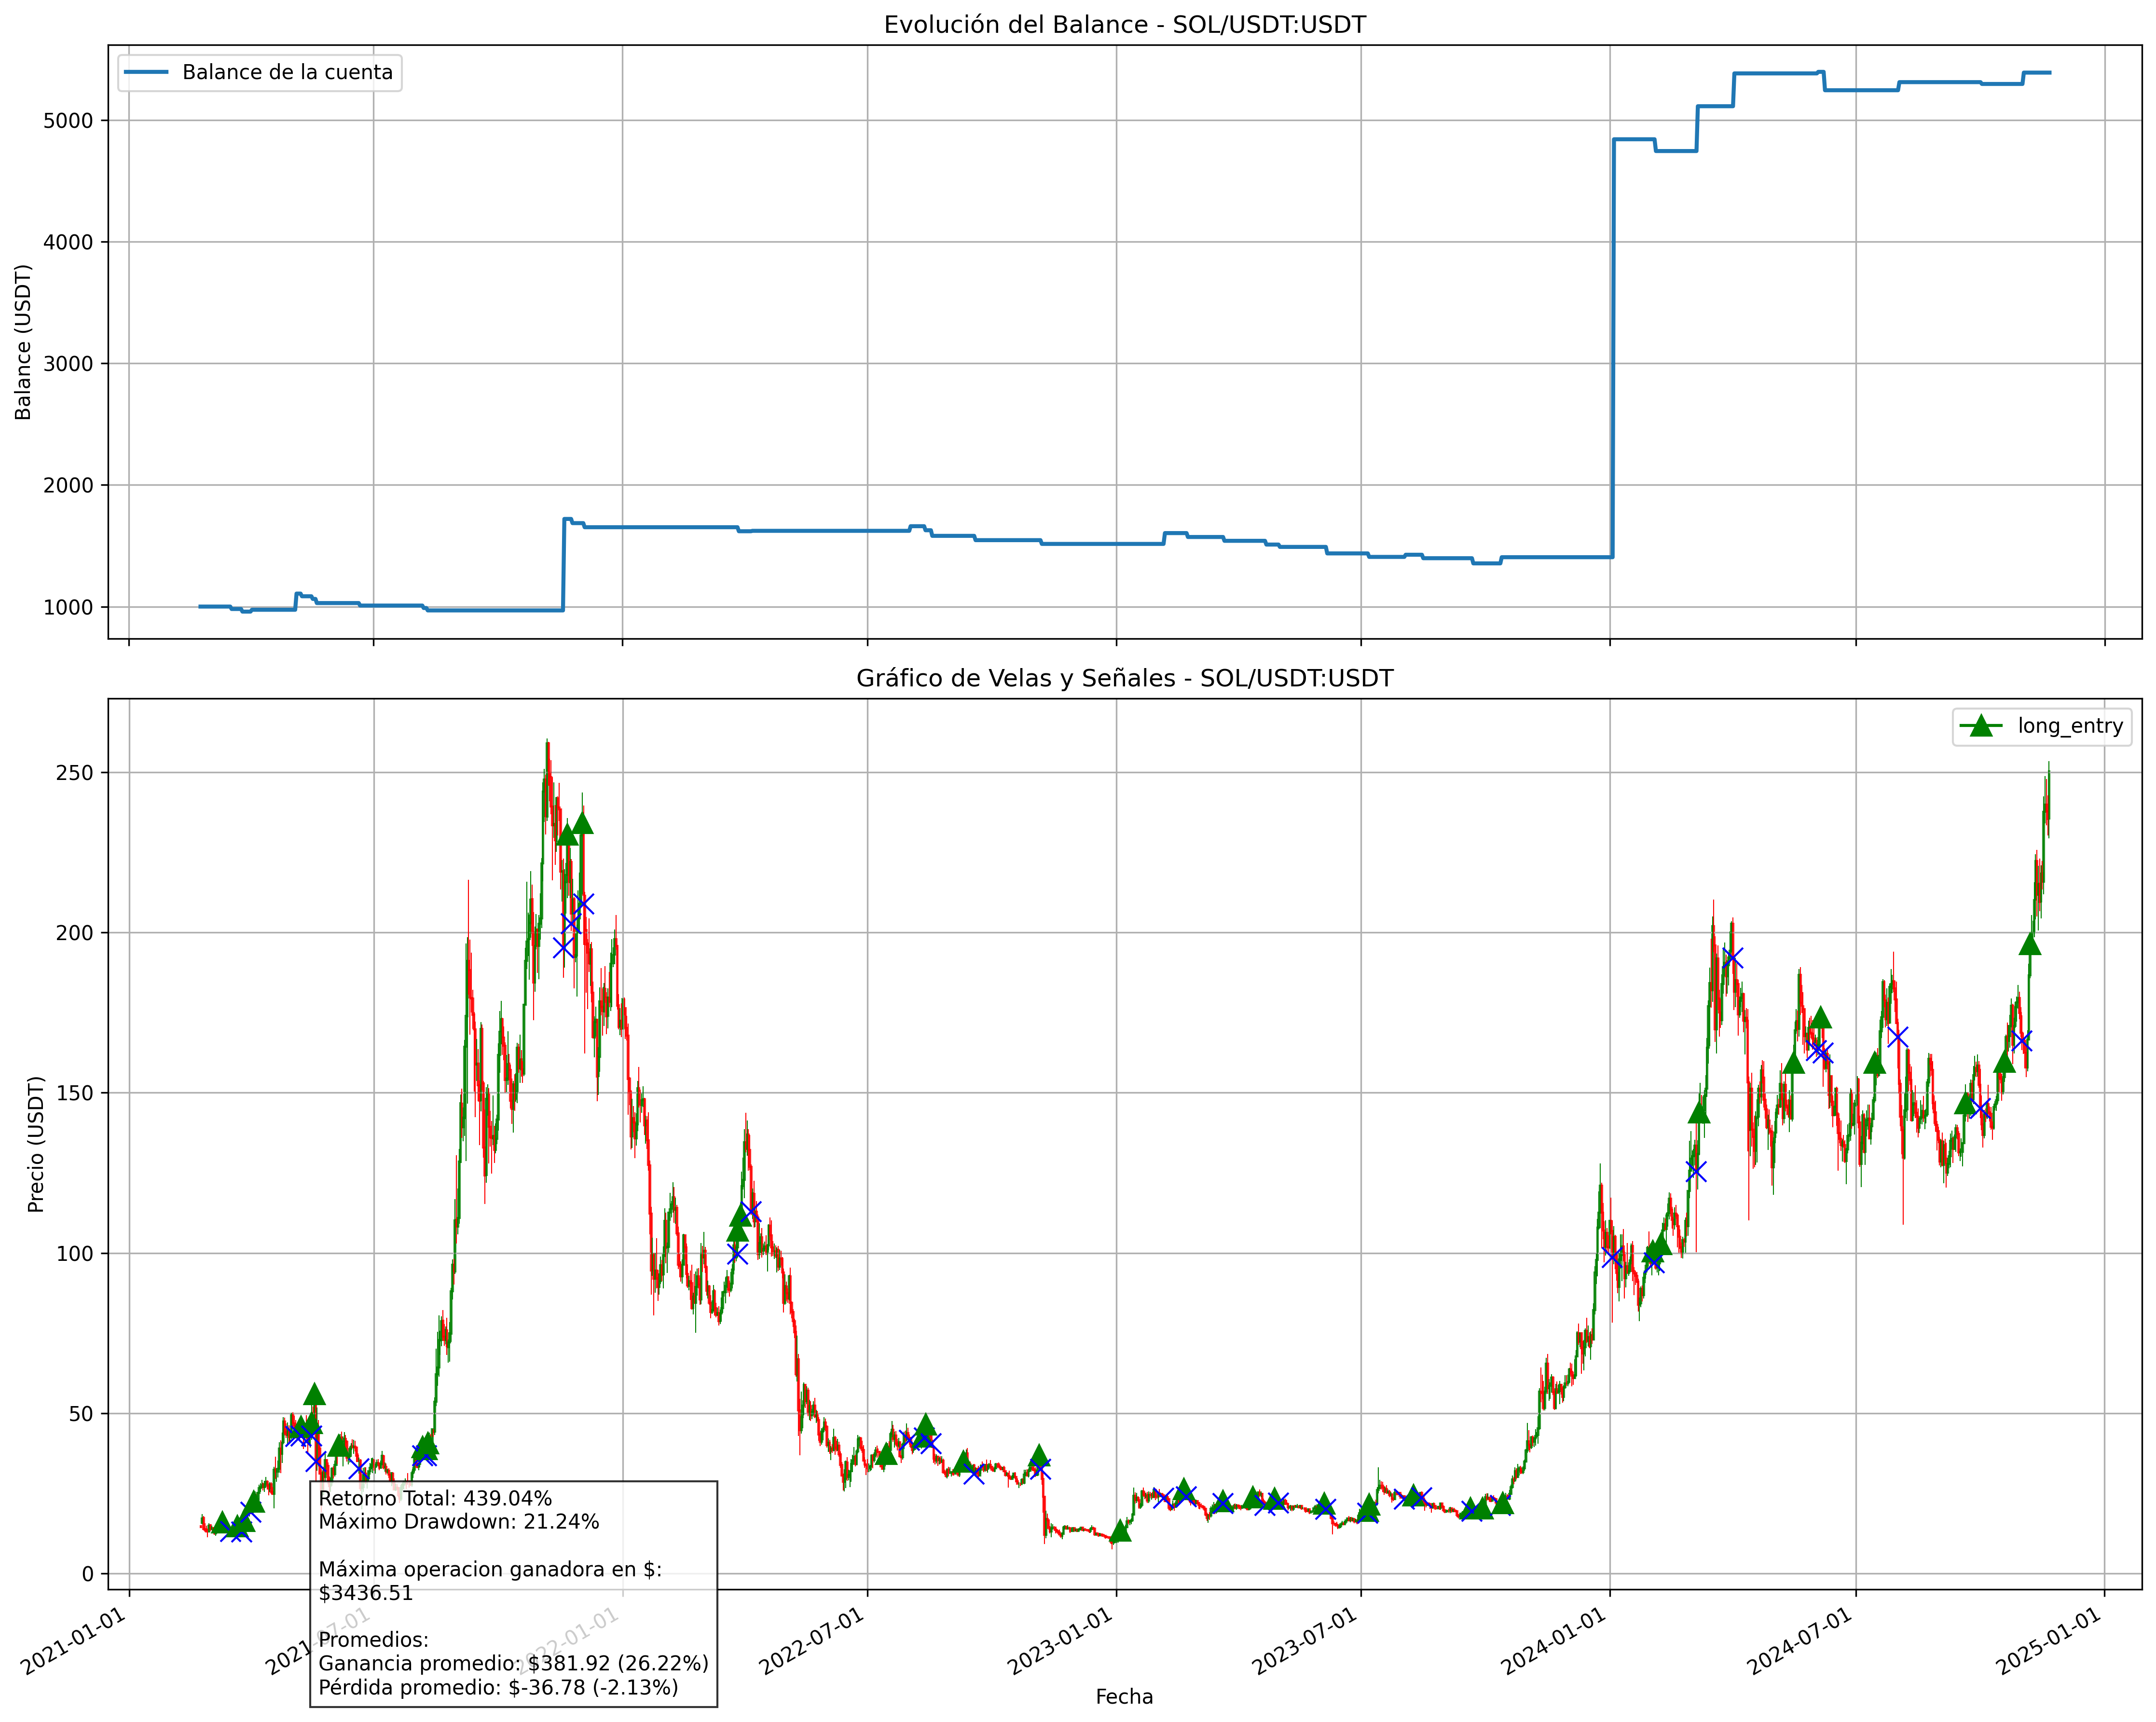


=== HISTORIAL DETALLADO DE OPERACIONES ===
   Fecha Entrada Fecha Salida  Tipo  Tipo Salida  Precio Entrada  Precio Salida  Volumen Asset  \
0     2021-03-11   2021-03-17  LONG    Stop Loss          16.044         13.163       6.942034   
1     2021-03-22   2021-03-25  LONG  Take Profit          14.824         13.010      11.800120   
2     2021-03-27   2021-04-01  LONG  Take Profit          16.480         19.080       5.779889   
3     2021-04-03   2021-05-04  LONG  Take Profit          22.440         42.770       6.547561   
4     2021-05-08   2021-05-08  LONG    Stop Loss          45.734         42.901       7.813161   
5     2021-05-16   2021-05-16  LONG    Stop Loss          47.034         42.901       5.248485   
6     2021-05-18   2021-05-19  LONG  Take Profit          56.024         35.009       1.619915   
7     2021-06-05   2021-06-20  LONG    Stop Loss          39.858         32.656       2.857165   
8     2021-08-06   2021-08-06  LONG    Stop Loss          39.492         3

In [22]:

from datetime import timedelta
timeframe = '1d'
exchange = ccxt.kucoinfutures()
markets = exchange.load_markets()
global_balance = initial_balance
short_trades = 0
long_trades = 0
short_trades_1 = 0
long_trades_1 = 0

def calculate_position_size(capital, risk_percentage, entry_price, stop_loss):
    """
    Calcula el tamaño de la posición basado en parámetros de riesgo
    """
    risk_amount = capital * (risk_percentage / 100)
    price_distance = abs(entry_price - stop_loss)
    if price_distance == 0:
        return 0
    position_size = risk_amount / price_distance
    return position_size

def get_ohlcv(symbol, timeframe, since, limit):
    """
    Obtiene datos OHLCV del exchange
    """
    return exchange.fetch_ohlcv(symbol, timeframe, since, limit)

def calculate_trade_metrics(trades_df, balance_history):
    """
    Calcula métricas detalladas de trading
    """
    # Calcular drawdown
    peak = balance_history[0]
    drawdowns = []
    for balance in balance_history:
        if balance > peak:
            peak = balance
        drawdown = (peak - balance) / peak * 100
        drawdowns.append(drawdown)
    max_drawdown = max(drawdowns)

    # Filtrar trades cerrados (exits y stops)
    closed_trades = trades_df[trades_df['type'].str.contains('exit|stop')].copy()

    # Calcular PnL por trade
    closed_trades.loc[:, 'pnl_percentage'] = closed_trades['pnl'] / (closed_trades['balance'] - closed_trades['pnl']) * 100

    # Máxima ganancia
    if not closed_trades.empty:
        max_profit_trade = closed_trades.loc[closed_trades['pnl'].idxmax()]
        max_profit_amount = max_profit_trade['pnl']
        max_profit_percentage = max_profit_trade['pnl_percentage']
    else:
        max_profit_amount = 0
        max_profit_percentage = 0

    # Promedio de ganancias y pérdidas
    winning_trades = closed_trades[closed_trades['pnl'] > 0]
    losing_trades = closed_trades[closed_trades['pnl'] < 0]

    avg_profit_amount = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
    avg_loss_amount = losing_trades['pnl'].mean() if len(losing_trades) > 0 else 0
    avg_profit_percentage = winning_trades['pnl_percentage'].mean() if len(winning_trades) > 0 else 0
    avg_loss_percentage = losing_trades['pnl_percentage'].mean() if len(losing_trades) > 0 else 0

    return {
        'max_drawdown': max_drawdown,
        'max_profit_amount': max_profit_amount,
        'max_profit_percentage': max_profit_percentage,
        'avg_profit_amount': avg_profit_amount,
        'avg_loss_amount': avg_loss_amount,
        'avg_profit_percentage': avg_profit_percentage,
        'avg_loss_percentage': avg_loss_percentage
    }

def backtest_strategy(df, initial_balance=initial_balance, risk_percentage=risk_percentage_value):
    """
    Ejecuta el backtest de la estrategia con gestión de posición
    """
    balance = initial_balance
    positions = []
    balance_history = [initial_balance]
    position_active = False
    current_position = None

    for i in range(1, len(df)):
        if df['rsi'].iloc[i] is None:
            continue

        balance_history.append(balance)

        # Gestión de salidas de posiciones existentes
        if position_active and current_position is not None:
            if current_position['type'] == 'long' and df['close_long'].iloc[i]:
                exit_price = df['close'].iloc[i]
                pnl = (exit_price - current_position['entry_price']) * current_position['size']
                balance += pnl
                position_active = False
                positions.append({
                    'type': 'long_exit',
                    'date': df['timestamp'].iloc[i],
                    'price': exit_price,
                    'balance': balance,
                    'pnl': pnl
                })

            elif current_position['type'] == 'short' and df['close_short'].iloc[i]:
                exit_price = df['close'].iloc[i]
                pnl = (current_position['entry_price'] - exit_price) * current_position['size']
                balance += pnl
                position_active = False
                positions.append({
                    'type': 'short_exit',
                    'date': df['timestamp'].iloc[i],
                    'price': exit_price,
                    'balance': balance,
                    'pnl': pnl
                })

        # Entradas de nuevas posiciones
        if not position_active:
            if df['long_condition'].iloc[i]:
                entry_price = df['close'].iloc[i]
                stop_loss = df['close_monthly'].iloc[i]
                position_size = calculate_position_size(balance, risk_percentage, entry_price, stop_loss)

                current_position = {
                    'type': 'long',
                    'entry_price': entry_price,
                    'stop_loss': stop_loss,
                    'size': position_size
                }
                position_active = True

                positions.append({
                    'type': 'long_entry',
                    'date': df['timestamp'].iloc[i],
                    'price': entry_price,
                    'size': position_size,
                    'balance': balance
                })

            elif df['short_condition'].iloc[i]:
                entry_price = df['close'].iloc[i]
                stop_loss = df['close_monthly'].iloc[i]
                position_size = calculate_position_size(balance, risk_percentage, entry_price, stop_loss)

                current_position = {
                    'type': 'short',
                    'entry_price': entry_price,
                    'stop_loss': stop_loss,
                    'size': position_size
                }
                position_active = True

                positions.append({
                    'type': 'short_entry',
                    'date': df['timestamp'].iloc[i],
                    'price': entry_price,
                    'size': position_size,
                    'balance': balance
                })

        # Verificación de stop loss
        if position_active and current_position is not None:
            if current_position['type'] == 'long' and df['low'].iloc[i] <= current_position['stop_loss']:
                exit_price = current_position['stop_loss']
                pnl = (exit_price - current_position['entry_price']) * current_position['size']
                balance += pnl
                position_active = False
                positions.append({
                    'type': 'long_stop',
                    'date': df['timestamp'].iloc[i],
                    'price': exit_price,
                    'balance': balance,
                    'pnl': pnl
                })

            elif current_position['type'] == 'short' and df['high'].iloc[i] >= current_position['stop_loss']:
                exit_price = current_position['stop_loss']
                pnl = (current_position['entry_price'] - exit_price) * current_position['size']
                balance += pnl
                position_active = False
                positions.append({
                    'type': 'short_stop',
                    'date': df['timestamp'].iloc[i],
                    'price': exit_price,
                    'balance': balance,
                    'pnl': pnl
                })

    return pd.DataFrame(positions), balance_history

def plot_balance_evolution(df_trades, balance_history, df, asset):
    """
    Genera dos subplots: evolución del balance y gráfico de velas con señales
    """
    metrics = calculate_trade_metrics(df_trades, balance_history)

    # Crear figura con dos subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), height_ratios=[1, 1.5])
    plt.subplots_adjust(hspace=0.3)

    # Subplot 1: Evolución del balance
    dates = df['timestamp'].values
    balance_dates = dates[:len(balance_history)]  # Usar las fechas correspondientes
    ax1.plot(balance_dates, balance_history, label='Balance de la cuenta', linewidth=2)
    ax1.set_title(f'Evolución del Balance - {asset}')
    ax1.set_xlabel('Fecha')
    ax1.set_ylabel('Balance (USDT)')
    ax1.grid(True)
    ax1.legend()

    # Formatear fechas en el eje x
    ax1.xaxis.set_major_formatter(mpdates.DateFormatter('%Y-%m-%d'))
    ax1.xaxis.set_major_locator(mpdates.AutoDateLocator())

    # Subplot 2: Gráfico de velas y señales
    # Preparar datos para el gráfico de velas
    df_ohlc = df[['timestamp', 'open', 'high', 'low', 'close']].copy()
    df_ohlc['timestamp'] = df_ohlc['timestamp'].map(mpdates.date2num)

    # Dibujar velas japonesas
    candlestick_ohlc(ax2, df_ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)

    # Añadir señales de entrada y salida
    for _, trade in df_trades.iterrows():
        date = mpdates.date2num(trade['date'])
        if 'entry' in trade['type']:
            marker = '^' if 'long' in trade['type'] else 'v'
            color = 'g' if 'long' in trade['type'] else 'r'
            ax2.plot(date, trade['price'], marker=marker, color=color, markersize=10, label=trade['type'])
        elif 'exit' in trade['type'] or 'stop' in trade['type']:
            marker = 'x'
            color = 'blue'
            ax2.plot(date, trade['price'], marker=marker, color=color, markersize=10)

    # Configurar el gráfico de velas
    ax2.set_title(f'Gráfico de Velas y Señales - {asset}')
    ax2.set_xlabel('Fecha')
    ax2.set_ylabel('Precio (USDT)')
    ax2.grid(True)
    ax2.xaxis.set_major_formatter(mpdates.DateFormatter('%Y-%m-%d'))
    ax2.xaxis.set_major_locator(mpdates.AutoDateLocator())

    # Añadir leyenda sin duplicados
    handles, labels = ax2.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax2.legend(by_label.values(), by_label.keys())

    # Rotar etiquetas de fecha para mejor visualización
    plt.gcf().autofmt_xdate()

    # Texto con métricas
    metrics_text = (
        f'Retorno Total: {((balance_history[-1] - balance_history[0]) / balance_history[0] * 100):.2f}%\n'
        f'Máximo Drawdown: {metrics["max_drawdown"]:.2f}%\n'
        f'\nMáxima operacion ganadora en $:\n'
        f'${metrics["max_profit_amount"]:.2f}\n'
        f'\nPromedios:\n'
        f'Ganancia promedio: ${metrics["avg_profit_amount"]:.2f} ({metrics["avg_profit_percentage"]:.2f}%)\n'
        f'Pérdida promedio: ${metrics["avg_loss_amount"]:.2f} ({metrics["avg_loss_percentage"]:.2f}%)'
    )

    # Añadir texto con métricas
    plt.figtext(0.15, 0.02, metrics_text,
                bbox=dict(facecolor='white', alpha=0.8),
                fontsize=10)

    plt.tight_layout()
    plt.show()

# Ejecución principal
for asset in assets:
    print(f"\nAnalizando {asset}")

    try:
        # Preparación de datos
        df = pd.DataFrame()
        os.makedirs(f'kucoin_{asset}', exist_ok=True)
        symbol = asset

        # Obtención de datos históricos
        current_date = start_date
        while current_date <= end_date:
            timestamp = int(current_date.timestamp() * 1000)
            ohlcv = get_ohlcv(symbol, timeframe, timestamp, 200)
            data = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
            df = pd.concat([df, data], ignore_index=True)
            current_date += datetime.timedelta(days=200)

        # Procesamiento de datos
        df.set_index('timestamp', inplace=True)
        df['year'] = df.index.year
        df['month'] = df.index.month

        # Cálculo del cierre mensual
        first_day_open = df.groupby(['year', 'month'])['open'].first()
        first_day_open = first_day_open.reset_index()
        first_day_open['timestamp'] = pd.to_datetime(first_day_open[['year', 'month']].astype(str).apply(lambda x: '-'.join(x), axis=1))
        first_day_open['month'] = first_day_open['month']

        df = df.merge(first_day_open, on=['year', 'month', 'timestamp'], how='left')
        df = df.rename(columns={'open_x': 'open', 'open_y': 'close_monthly'})
        df['close_monthly'] = df['close_monthly'].ffill()
        df = df.drop(columns=['year', 'month'])
        df.reset_index(inplace=True)

        # Cálculo de indicadores
        df['rsi'] = ta.rsi(close=df['close'], length=14)
        df['sma100'] = ta.sma(df['close'], length=100)
        df['close_long'] = df['close'] < df['close_monthly']
        df['close_short'] = df['close'] > df['close_monthly']

        # Condiciones de entrada
        # Condiciones de entrada
        df['long_condition'] = (
            (df['close'] > df['open']) &
            (df['open'] > df['close_monthly']) &
            (df['close'].shift(1) > df['close_monthly']) &
            (df['rsi'].shift(1) > 50))

        df['short_condition'] = (
            (df['close'] > df['sma100']) &
            (df['open'] < df['close_monthly']) &
            (df['close'].shift(1) < df['close_monthly']) &
            (df['rsi'].shift(1) < 10))

        # Ejecución del backtest
        trades_df, balance_history = backtest_strategy(df, initial_balance=initial_balance, risk_percentage=risk_percentage_value)

        # Calcular métricas
        metrics = calculate_trade_metrics(trades_df, balance_history)

        # Estadísticas de trading
        profitable_trades = trades_df[trades_df['type'].str.contains('exit')]['pnl'].apply(lambda x: x > 0).sum()
        total_trades = len(trades_df[trades_df['type'].str.contains('exit|stop')])

        print(f"\nEstadísticas de Trading para {asset} por riesgo % del balance total:")
        print(f"Balance Inicial: {initial_balance}  USDT")
        print(f"Balance Final: {balance_history[-1]:.2f} USDT")
        print(f"Retorno Total: {((balance_history[-1] - initial_balance) / initial_balance * 100):.2f}%")
        print(f"Operaciones Totales: {total_trades}")
        if total_trades > 0:
            win_rate=float(profitable_trades/total_trades*100)
            print(f"Porcentaje de Aciertos: {(profitable_trades/total_trades*100):.2f}%")

        print(f"\nMétricas Detalladas:")
        print(f"Máximo Drawdown: {metrics['max_drawdown']:.2f}%")
        print(f"Máxima operacion ganadora en $: ${metrics['max_profit_amount']:.2f})")
        print(f"\nPromedios:")
        print(f"Ganancia promedio: ${metrics['avg_profit_amount']:.2f} ")
        print(f"Pérdida promedio: ${metrics['avg_loss_amount']:.2f}")

        # Visualización de resultados
        plot_balance_evolution(trades_df, balance_history, df, asset)

    except Exception as e:
        print(f"Error al procesar {asset}: {str(e)}")
import pandas as pd

def generate_trading_history(trades_df):
    """
    Genera un historial detallado de operaciones a partir del DataFrame de trades

    Parameters:
    trades_df (pd.DataFrame): DataFrame con el historial de operaciones

    Returns:
    pd.DataFrame: Historial detallado de operaciones
    """
    # Crear listas para almacenar las operaciones completas
    complete_trades = []
    current_trade = None

    for _, trade in trades_df.iterrows():
        if 'entry' in trade['type']:
            # Guardar entrada
            current_trade = {
                'entry_date': trade['date'],
                'entry_price': trade['price'],
                'position_size': trade['size'],
                'trade_type': 'LONG' if 'long' in trade['type'] else 'SHORT',
                'initial_balance': trade['balance']
            }

        elif ('exit' in trade['type'] or 'stop' in trade['type']) and current_trade is not None:
            # Completar la operación con datos de salida
            current_trade.update({
                'exit_date': trade['date'],
                'exit_price': trade['price'],
                'exit_type': 'Stop Loss' if 'stop' in trade['type'] else 'Take Profit',
                'final_balance': trade['balance'],
                'pnl': trade['pnl']
            })

            # Calcular métricas adicionales
            trade_volume_usd = current_trade['position_size'] * current_trade['entry_price']
            return_percentage = (trade['pnl'] / trade_volume_usd) * 100 if trade_volume_usd != 0 else 0

            current_trade.update({
                'trade_volume_usd': trade_volume_usd,
                'return_percentage': return_percentage
            })

            complete_trades.append(current_trade)
            current_trade = None

    # Crear DataFrame con el historial
    history_df = pd.DataFrame(complete_trades)

    # Formatear columnas
    if not history_df.empty:
        history_df = history_df.round({
            'entry_price': 4,
            'exit_price': 4,
            'position_size': 6,
            'trade_volume_usd': 2,
            'pnl': 2,
            'return_percentage': 2
        })

        # Reordenar columnas
        columns_order = [
            'entry_date', 'exit_date', 'trade_type', 'exit_type',
            'entry_price', 'exit_price', 'position_size', 'trade_volume_usd',
            'pnl', 'return_percentage', 'initial_balance', 'final_balance'
        ]
        history_df = history_df[columns_order]

        # Renombrar columnas para mejor legibilidad
        history_df.columns = [
            'Fecha Entrada', 'Fecha Salida', 'Tipo', 'Tipo Salida',
            'Precio Entrada', 'Precio Salida', 'Volumen Asset', 'Volumen USD',
            'PnL', 'Retorno %', 'Balance Inicial', 'Balance Final'
        ]

    return history_df

def print_trading_summary(history_df):
    """
    Imprime un resumen del historial de trading

    Parameters:
    history_df (pd.DataFrame): DataFrame con el historial de operaciones
    """
    if history_df.empty:
        print("No hay operaciones para analizar")
        return

    print("\n=== RESUMEN DE OPERACIONES ===")
    print(f"\nTotal de operaciones: {len(history_df)}")
    print(f"Operaciones ganadoras: {len(history_df[history_df['PnL'] > 0])}")
    print(f"Operaciones perdedoras: {len(history_df[history_df['PnL'] < 0])}")

    print(f"\nPnL total: ${history_df['PnL'].sum():.2f}")
    print(f"PnL promedio por operación: ${history_df['PnL'].mean():.2f}")
    print(f"Retorno promedio: {history_df['Retorno %'].mean():.2f}%")

    print(f"\nMejor operación: ${history_df['PnL'].max():.2f}")
    print(f"Peor operación: ${history_df['PnL'].min():.2f}")

    print(f"\nVolumen total operado: ${history_df['Volumen USD'].sum():.2f}")
    print(f"Volumen promedio por operación: ${history_df['Volumen USD'].mean():.2f}")

# Ejemplo de uso:
def analyze_trading_history(trades_df):
    """
    Analiza y muestra el historial completo de trading

    Parameters:
    trades_df (pd.DataFrame): DataFrame con las operaciones
    """
    # Generar historial detallado
    history_df = generate_trading_history(trades_df)

    # Mostrar historial completo
    if not history_df.empty:
        print("\n=== HISTORIAL DETALLADO DE OPERACIONES ===")
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        print(history_df)

        # Mostrar resumen
        #print_trading_summary(history_df)
    else:
        print("No se encontraron operaciones para analizar")

    return history_df

# Analizar el historial de operaciones
trading_history = analyze_trading_history(trades_df)

import pandas as pd

def generate_trading_history_with_monthly_returns(trades_df):
  """
  Genera un historial detallado de operaciones incluyendo retornos mensuales en dinero y porcentaje.
  """
  history_df = generate_trading_history(trades_df)

  if history_df.empty:
    return history_df, pd.DataFrame()

  history_df['Balance Mensual'] = 0.0
  history_df['Mes'] = pd.to_datetime(history_df['Fecha Entrada']).dt.to_period('M')

  balance_mensual = history_df['Balance Inicial'].iloc[0]
  for index, row in history_df.iterrows():
    balance_mensual += row['PnL']
    history_df.loc[index, 'Balance Mensual'] = balance_mensual

  monthly_returns = history_df.groupby('Mes')['Balance Mensual'].last().reset_index()
  monthly_returns['Mes'] = monthly_returns['Mes'].dt.to_timestamp()

  monthly_returns['Retorno Mensual'] = 0.0
  monthly_returns['Retorno Mensual %'] = 0.0
  balance_anterior = history_df['Balance Inicial'].iloc[0]

  for index, row in monthly_returns.iterrows():
    if index == 0:
      retorno_dinero = row['Balance Mensual'] - balance_anterior
      retorno_porcentaje = (retorno_dinero / balance_anterior) * 100
    else:
      retorno_dinero = row['Balance Mensual'] - monthly_returns['Balance Mensual'].iloc[index - 1]
      retorno_porcentaje = (retorno_dinero / monthly_returns['Balance Mensual'].iloc[index - 1]) * 100

    monthly_returns.loc[index, 'Retorno Mensual'] = retorno_dinero
    monthly_returns.loc[index, 'Retorno Mensual %'] = retorno_porcentaje

  return history_df, monthly_returns

# Ejemplo de uso (necesitarás crear un DataFrame trades_df)
# Supongamos que tienes un DataFrame llamado 'trades_df' con tus datos de trading
# trades_df = ... # Tu DataFrame aquí

history_df, monthly_returns = generate_trading_history_with_monthly_returns(trades_df)
# print_trading_summary(history_df)
# print("\n=== Retornos Mensuales ===")
print(monthly_returns)



Archivo percent_de_balance.xlsx generado exitosamente.


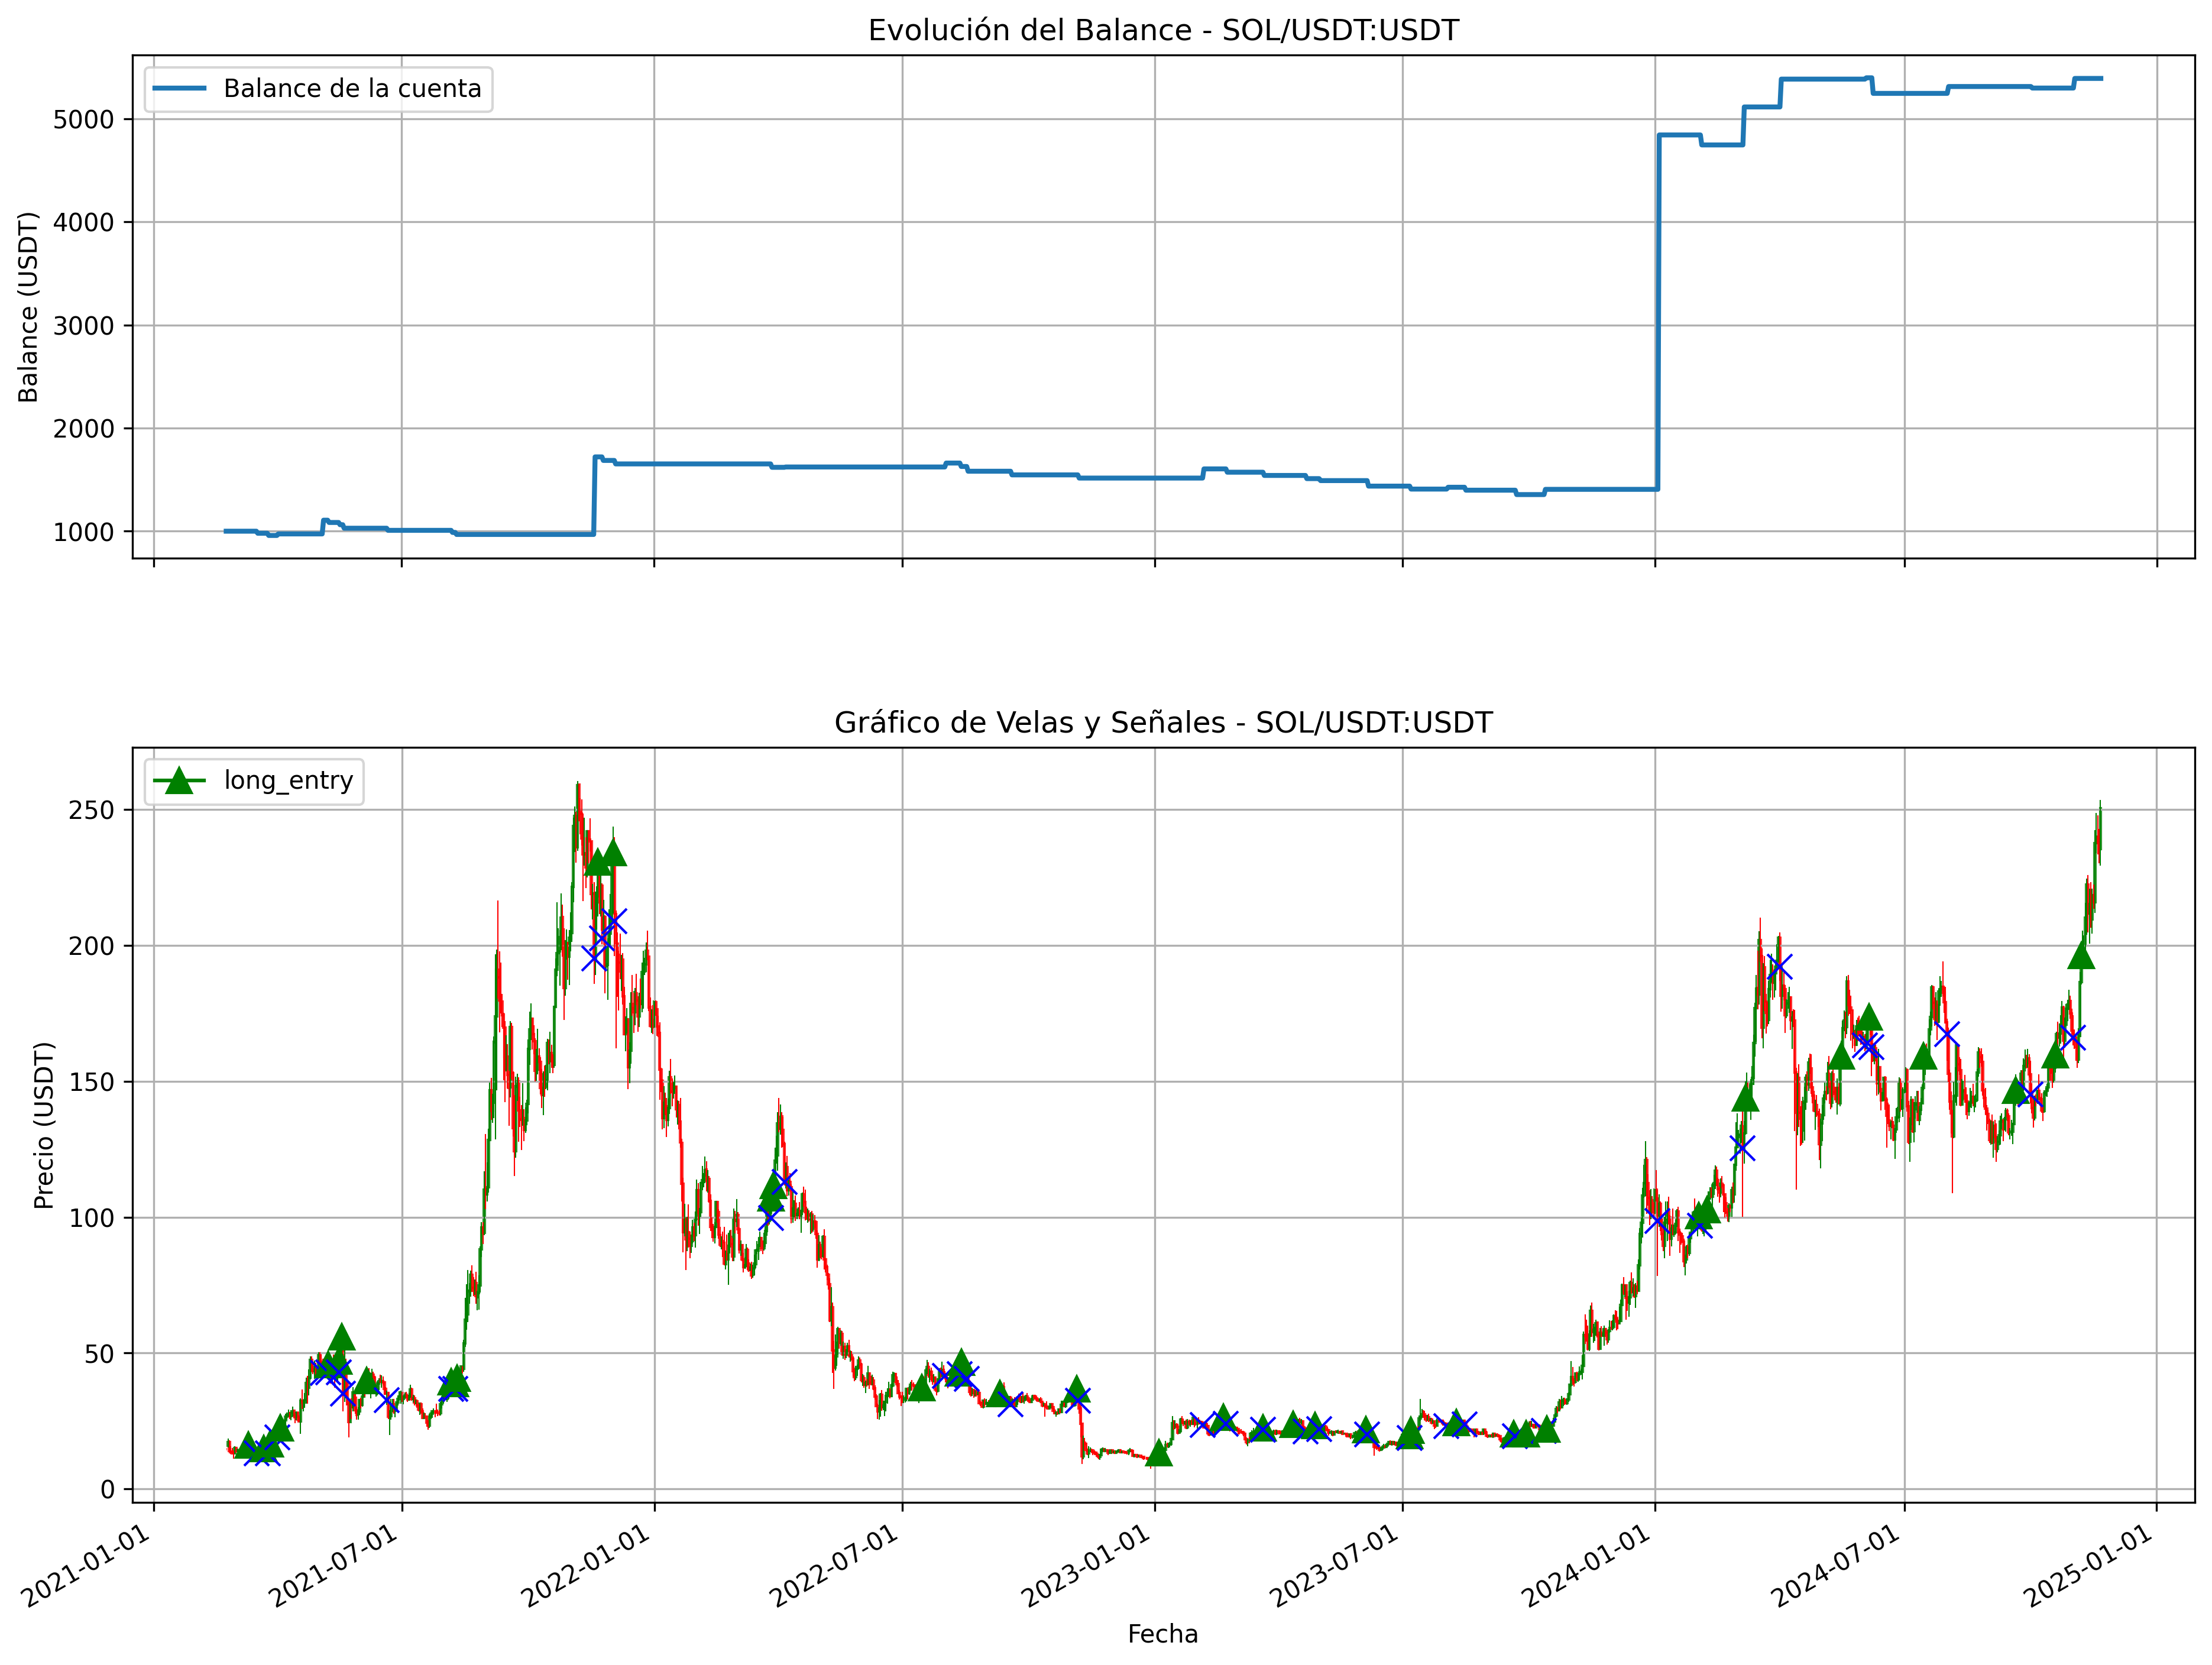

In [23]:
import openpyxl
from openpyxl.drawing.image import Image
from openpyxl.styles import Font, Alignment, Border, Side, PatternFill, NamedStyle, numbers
from openpyxl.utils.dataframe import dataframe_to_rows
import matplotlib.pyplot as plt
import matplotlib.dates as mpdates
import io
import pandas as pd
import numpy as np
#print(f"Operaciones Totales: {total_trades}")
#win_rate=float(profitable_trades/total_trades*100)
def save_trading_report_to_excel(trades_df, balance_history, df, asset, monthly_returns):
    """
    Genera un archivo Excel con plots, métricas y datos de trading
    """
    # Crear workbook y hojas
    wb = openpyxl.Workbook()

    percent_de_balance="percent_de_balance"
    # Hoja de Resumen
    ws_summary = wb.active
    ws_summary.title = f"Resumen {percent_de_balance}"

    # Definir estilos
    header_font = Font(bold=True, size=12)
    border_style = Border(
        left=Side(style='thin'),
        right=Side(style='thin'),
        top=Side(style='thin'),
        bottom=Side(style='thin')
    )
    header_fill = PatternFill(start_color="D3D3D3", end_color="D3D3D3", fill_type="solid")

    # Métricas principales
    metrics = calculate_trade_metrics(trades_df, balance_history)

    summary_metrics = [
        ["Métrica", "Valor"],
        ["Balance Inicial", f"{initial_balance} USDT"],
        ["Balance Final", f"{balance_history[-1]:.2f} USDT"],
        ["Retorno Total", f"{((balance_history[-1] - initial_balance) / initial_balance * 100):.2f}%"],
        ["Máximo Drawdown", f"{metrics['max_drawdown']:.2f}%"],
        ["Máxima Operación Ganadora", f"${metrics['max_profit_amount']:.2f}"],
        ["Ganancia Promedio", f"${metrics['avg_profit_amount']:.2f}"],
        ["Pérdida Promedio", f"${metrics['avg_loss_amount']:.2f}"],
        ["Total de operaciones", f"{total_trades:.2f}"],
        ["Winrate", f"%{win_rate:.2f}"]
    ]

    # Escribir métricas de resumen
    for row_idx, row_data in enumerate(summary_metrics, start=1):
        for col_idx, value in enumerate(row_data, start=1):
            cell = ws_summary.cell(row=row_idx, column=col_idx, value=value)
            cell.border = border_style
            if row_idx == 1:
                cell.font = header_font
                cell.fill = header_fill

    # Hoja de Historial de Trades
    ws_trades = wb.create_sheet(title="Historial de Trades")

    # Generar historial de trading con función existente
    history_df = generate_trading_history(trades_df)

    # Crear estilo para fechas
    date_style = NamedStyle(name='datetime')
    date_style.number_format = 'DD/MM/YYYY'

    # Escribir historial de trades
    for row_idx, column_name in enumerate(history_df.columns, start=1):
        ws_trades.cell(row=1, column=row_idx, value=column_name).font = header_font

    for row_idx, row_data in enumerate(history_df.values.tolist(), start=2):
        for col_idx, value in enumerate(row_data, start=1):
            cell = ws_trades.cell(row=row_idx, column=col_idx, value=value)

            # Aplicar estilo de fecha para columnas de fecha
            if isinstance(value, pd.Timestamp):
                cell.style = date_style

            # Formatear columnas numéricas
            if isinstance(value, (int, float)):
                if 'Precio' in history_df.columns[col_idx-1] or 'PnL' in history_df.columns[col_idx-1] or 'Retorno' in history_df.columns[col_idx-1]:
                    cell.number_format = '0.00'
                elif 'Volumen' in history_df.columns[col_idx-1]:
                    cell.number_format = '0.00'

    # Hoja de Retornos Mensuales
    ws_monthly = wb.create_sheet(title="Retornos Mensuales")

    for row_idx, column_name in enumerate(monthly_returns.columns, start=1):
        ws_monthly.cell(row=1, column=row_idx, value=column_name).font = header_font

    for row_idx, row_data in enumerate(monthly_returns.values.tolist(), start=2):
        for col_idx, value in enumerate(row_data, start=1):
            cell = ws_monthly.cell(row=row_idx, column=col_idx, value=value)

            # Aplicar estilo de fecha para columnas de fecha
            if isinstance(value, pd.Timestamp):
                cell.style = date_style

            # Formatear columnas numéricas
            if isinstance(value, (int, float)):
                if 'Retorno' in monthly_returns.columns[col_idx-1]:
                    cell.number_format = '0.00'

    # Generar plots y guardar en Excel
    plt.close('all')  # Cerrar cualquier figura existente

    # Configuración para alta calidad de imagen
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300

    # Recrear la figura con configuraciones para alta calidad
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), height_ratios=[1, 1.5])
    plt.subplots_adjust(hspace=0.3)

    # Subplot 1: Evolución del balance
    dates = df['timestamp'].values
    balance_dates = dates[:len(balance_history)]  # Usar las fechas correspondientes
    ax1.plot(balance_dates, balance_history, label='Balance de la cuenta', linewidth=2)
    ax1.set_title(f'Evolución del Balance - {asset}')
    ax1.set_xlabel('Fecha')
    ax1.set_ylabel('Balance (USDT)')
    ax1.grid(True)
    ax1.legend()

    # Formatear fechas en el eje x
    ax1.xaxis.set_major_formatter(mpdates.DateFormatter('%Y-%m-%d'))
    ax1.xaxis.set_major_locator(mpdates.AutoDateLocator())

    # Subplot 2: Gráfico de velas y señales
    # Preparar datos para el gráfico de velas
    df_ohlc = df[['timestamp', 'open', 'high', 'low', 'close']].copy()
    df_ohlc['timestamp'] = df_ohlc['timestamp'].map(mpdates.date2num)

    # Dibujar velas japonesas
    from mplfinance.original_flavor import candlestick_ohlc
    candlestick_ohlc(ax2, df_ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)

    # Añadir señales de entrada y salida
    for _, trade in trades_df.iterrows():
        date = mpdates.date2num(trade['date'])
        if 'entry' in trade['type']:
            marker = '^' if 'long' in trade['type'] else 'v'
            color = 'g' if 'long' in trade['type'] else 'r'
            ax2.plot(date, trade['price'], marker=marker, color=color, markersize=10, label=trade['type'])
        elif 'exit' in trade['type'] or 'stop' in trade['type']:
            marker = 'x'
            color = 'blue'
            ax2.plot(date, trade['price'], marker=marker, color=color, markersize=10)

    # Configurar el gráfico de velas
    ax2.set_title(f'Gráfico de Velas y Señales - {asset}')
    ax2.set_xlabel('Fecha')
    ax2.set_ylabel('Precio (USDT)')
    ax2.grid(True)
    ax2.xaxis.set_major_formatter(mpdates.DateFormatter('%Y-%m-%d'))
    ax2.xaxis.set_major_locator(mpdates.AutoDateLocator())

    # Añadir leyenda sin duplicados
    handles, labels = ax2.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax2.legend(by_label.values(), by_label.keys())

    # Rotar etiquetas de fecha para mejor visualización
    plt.gcf().autofmt_xdate()

    # Guardar imagen en alta calidad
    img_buffer = io.BytesIO()
    plt.savefig(img_buffer, format='png', dpi=300, bbox_inches='tight')
    img_buffer.seek(0)

    # Agregar imagen al Excel
    img = Image(img_buffer)
    img.width = 800
    img.height = 600
    ws_summary.add_image(img, 'E2')

    # Ajustar anchos de columna
    for sheet in [ws_summary, ws_trades, ws_monthly]:
        for col in sheet.columns:
            max_length = 0
            column = col[0].column_letter
            for cell in col:
                try:
                    if len(str(cell.value)) > max_length:
                        max_length = len(cell.value)
                except:
                    pass
            adjusted_width = (max_length + 2)
            sheet.column_dimensions[column].width = adjusted_width

    # Guardar archivo
    filename = f'percent_de_balance.xlsx'
    wb.save(filename)
    print(f"Archivo {filename} generado exitosamente.")

# Llamada de ejemplo (ajusta con tus variables globales)
save_trading_report_to_excel(trades_df, balance_history, df, asset, monthly_returns)

# **Ejecucion de estrategia por gestion por monto fijo**

**Configuración inicial de estrategia por gestion por monto fijo**

In [24]:
Riesgo_Monto_Fijo=20 #dolares
assets="SOL/USDT:USDT"
balance_inicial=1000


Estadísticas de Trading para SOL/USDT:USDT con riesgo fijo de 20 USD:
Balance Inicial: 1000 USDT
Balance Final: 4116.63 USDT
Retorno Total: 311.66%
Operaciones Totales: 40
Porcentaje de Aciertos: 35.00%

Métricas Detalladas:
Máximo Drawdown: 13.27%
Máxima operación ganadora en $: $2444.47

Promedios:
Ganancia promedio: $262.22
Pérdida promedio: $-21.32


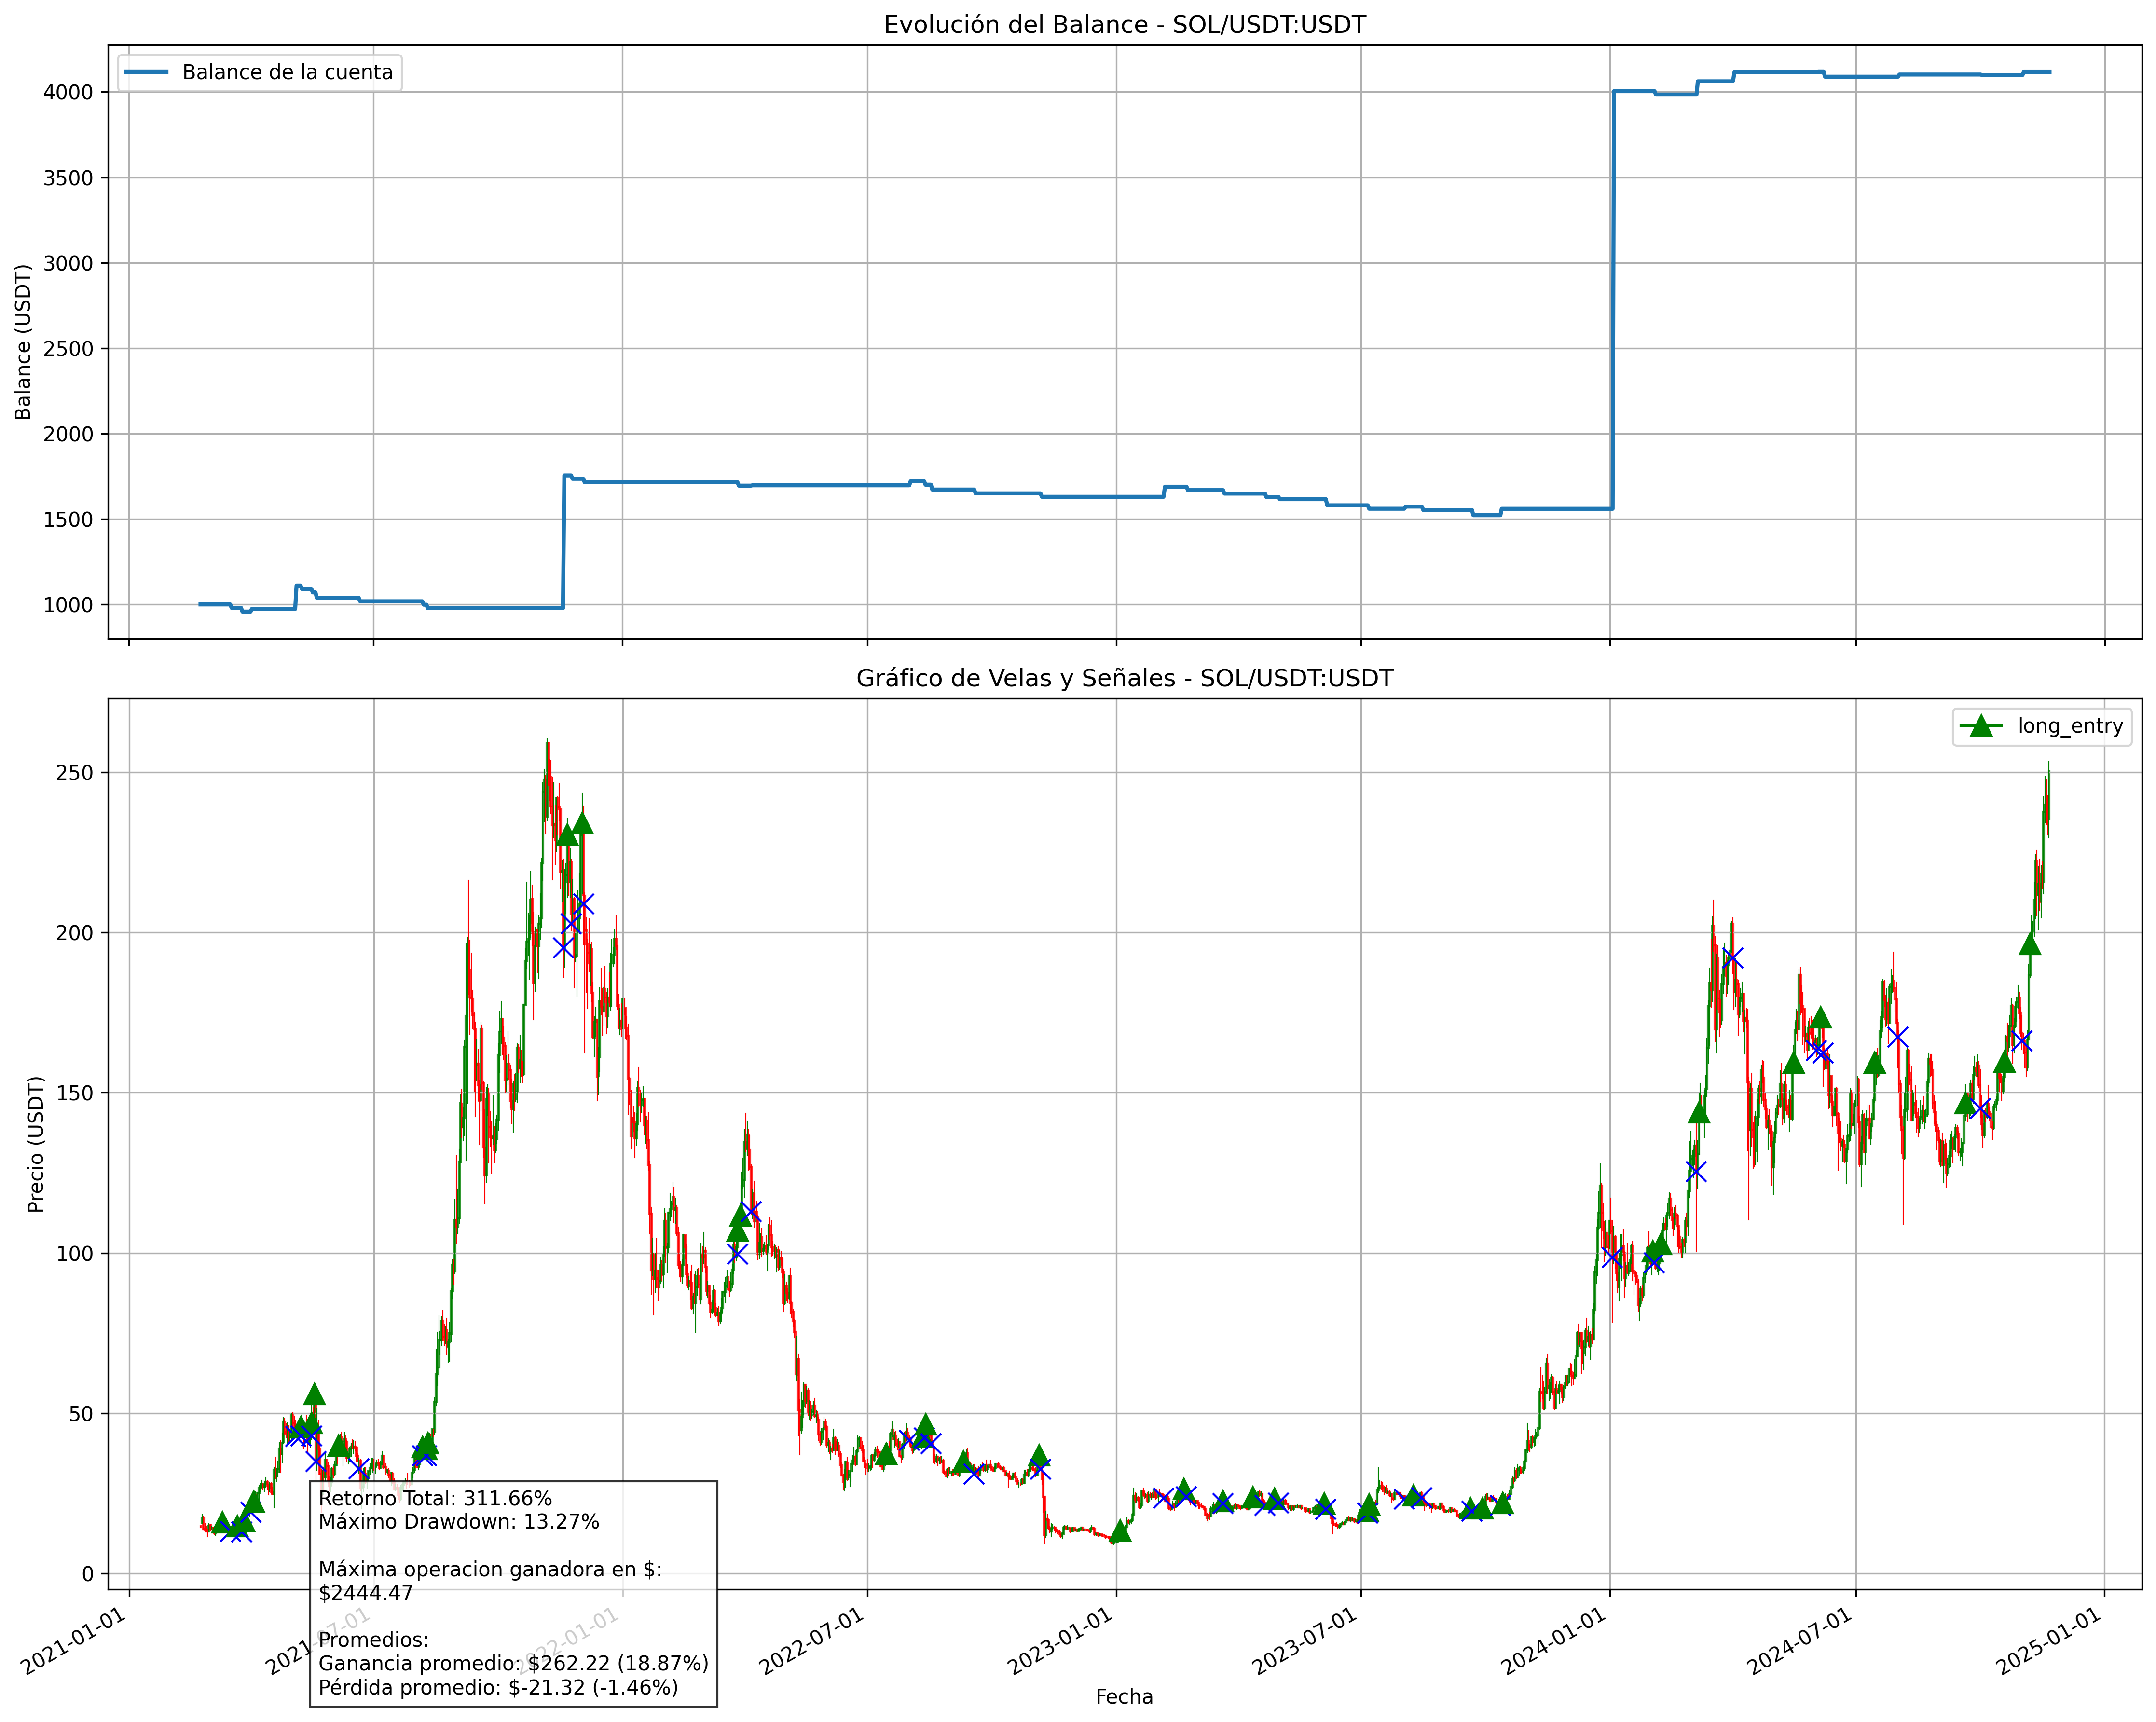


=== HISTORIAL DETALLADO DE OPERACIONES ===
   Fecha Entrada Fecha Salida  Tipo  Tipo Salida  Precio Entrada  Precio Salida  Volumen Asset  \
0     2021-03-11   2021-03-17  LONG    Stop Loss          16.044         13.163       6.942034   
1     2021-03-22   2021-03-25  LONG  Take Profit          14.824         13.010      12.040939   
2     2021-03-27   2021-04-01  LONG  Take Profit          16.480         19.080       6.029545   
3     2021-04-03   2021-05-04  LONG  Take Profit          22.440         42.770       6.724950   
4     2021-05-08   2021-05-08  LONG    Stop Loss          45.734         42.901       7.059654   
5     2021-05-16   2021-05-16  LONG    Stop Loss          47.034         42.901       4.839100   
6     2021-05-18   2021-05-19  LONG  Take Profit          56.024         35.009       1.524042   
7     2021-06-05   2021-06-20  LONG    Stop Loss          39.858         32.656       2.777006   
8     2021-08-06   2021-08-06  LONG    Stop Loss          39.492         3

In [25]:
fixed_risk_amount=Riesgo_Monto_Fijo

def calculate_position_size(capital, risk_percentage, entry_price, stop_loss, fixed_risk_amount=Riesgo_Monto_Fijo):
    """
    Calcula el tamaño de la posición basado en riesgo fijo

    """
    price_distance = abs(entry_price - stop_loss)
    if price_distance == 0:
        return 0
    position_size = fixed_risk_amount / price_distance
    return position_size

def calculate_trade_metrics(trades_df, balance_history):
    """
    Calcula métricas detalladas de trading
    """
    # Calcular drawdown
    peak = balance_history[0]
    drawdowns = []
    for balance in balance_history:
        if balance > peak:
            peak = balance
        drawdown = (peak - balance) / peak * 100
        drawdowns.append(drawdown)
    max_drawdown = max(drawdowns)

    # Filtrar trades cerrados (exits y stops)
    closed_trades = trades_df[trades_df['type'].str.contains('exit|stop')].copy()

    # Calcular PnL por trade
    closed_trades.loc[:, 'pnl_percentage'] = closed_trades['pnl'] / (closed_trades['balance'] - closed_trades['pnl']) * 100

    # Máxima ganancia
    if not closed_trades.empty:
        max_profit_trade = closed_trades.loc[closed_trades['pnl'].idxmax()]
        max_profit_amount = max_profit_trade['pnl']
        max_profit_percentage = max_profit_trade['pnl_percentage']
    else:
        max_profit_amount = 0
        max_profit_percentage = 0

    # Promedio de ganancias y pérdidas
    winning_trades = closed_trades[closed_trades['pnl'] > 0]
    losing_trades = closed_trades[closed_trades['pnl'] < 0]

    avg_profit_amount = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
    avg_loss_amount = losing_trades['pnl'].mean() if len(losing_trades) > 0 else 0
    avg_profit_percentage = winning_trades['pnl_percentage'].mean() if len(winning_trades) > 0 else 0
    avg_loss_percentage = losing_trades['pnl_percentage'].mean() if len(losing_trades) > 0 else 0

    return {
        'max_drawdown': max_drawdown,
        'max_profit_amount': max_profit_amount,
        'max_profit_percentage': max_profit_percentage,
        'avg_profit_amount': avg_profit_amount,
        'avg_loss_amount': avg_loss_amount,
        'avg_profit_percentage': avg_profit_percentage,
        'avg_loss_percentage': avg_loss_percentage
    }

def backtest_strategy(df, initial_balance=balance_inicial, fixed_risk_amount=Riesgo_Monto_Fijo):
    """
    Ejecuta el backtest de la estrategia con gestión de riesgo fijo
    """
    balance = initial_balance
    positions = []
    balance_history = [initial_balance]
    position_active = False
    current_position = None

    for i in range(1, len(df)):
        if df['rsi'].iloc[i] is None:
            continue

        balance_history.append(balance)

        # Gestión de salidas de posiciones existentes
        if position_active and current_position is not None:
            if current_position['type'] == 'long' and df['close_long'].iloc[i]:
                exit_price = df['close'].iloc[i]
                pnl = (exit_price - current_position['entry_price']) * current_position['size']
                balance += pnl
                position_active = False
                positions.append({
                    'type': 'long_exit',
                    'date': df['timestamp'].iloc[i],
                    'price': exit_price,
                    'balance': balance,
                    'pnl': pnl
                })

            elif current_position['type'] == 'short' and df['close_short'].iloc[i]:
                exit_price = df['close'].iloc[i]
                pnl = (current_position['entry_price'] - exit_price) * current_position['size']
                balance += pnl
                position_active = False
                positions.append({
                    'type': 'short_exit',
                    'date': df['timestamp'].iloc[i],
                    'price': exit_price,
                    'balance': balance,
                    'pnl': pnl
                })

        # Entradas de nuevas posiciones
        if not position_active:
            if df['long_condition'].iloc[i]:
                entry_price = df['close'].iloc[i]
                stop_loss = df['close_monthly'].iloc[i]
                position_size = calculate_position_size(
                    balance, 0, entry_price, stop_loss, fixed_risk_amount=fixed_risk_amount
                )

                current_position = {
                    'type': 'long',
                    'entry_price': entry_price,
                    'stop_loss': stop_loss,
                    'size': position_size
                }
                position_active = True

                positions.append({
                    'type': 'long_entry',
                    'date': df['timestamp'].iloc[i],
                    'price': entry_price,
                    'size': position_size,
                    'balance': balance
                })

            elif df['short_condition'].iloc[i]:
                entry_price = df['close'].iloc[i]
                stop_loss = df['close_monthly'].iloc[i]
                position_size = calculate_position_size(
                    balance, 0, entry_price, stop_loss, fixed_risk_amount=fixed_risk_amount
                )

                current_position = {
                    'type': 'short',
                    'entry_price': entry_price,
                    'stop_loss': stop_loss,
                    'size': position_size
                }
                position_active = True

                positions.append({
                    'type': 'short_entry',
                    'date': df['timestamp'].iloc[i],
                    'price': entry_price,
                    'size': position_size,
                    'balance': balance
                })

        # Verificación de stop loss
        if position_active and current_position is not None:
            if current_position['type'] == 'long' and df['low'].iloc[i] <= current_position['stop_loss']:
                exit_price = current_position['stop_loss']
                pnl = (exit_price - current_position['entry_price']) * current_position['size']
                balance += pnl
                position_active = False
                positions.append({
                    'type': 'long_stop',
                    'date': df['timestamp'].iloc[i],
                    'price': exit_price,
                    'balance': balance,
                    'pnl': pnl
                })

            elif current_position['type'] == 'short' and df['high'].iloc[i] >= current_position['stop_loss']:
                exit_price = current_position['stop_loss']
                pnl = (current_position['entry_price'] - exit_price) * current_position['size']
                balance += pnl
                position_active = False
                positions.append({
                    'type': 'short_stop',
                    'date': df['timestamp'].iloc[i],
                    'price': exit_price,
                    'balance': balance,
                    'pnl': pnl
                })

    return pd.DataFrame(positions), balance_history

# Ejecución principal del backtest
def run_backtest_analysis(asset, df, initial_balance=balance_inicial, fixed_risk_amount=Riesgo_Monto_Fijo):
    """
    Ejecuta el análisis completo del backtest para un activo
    """
    try:
        # Ejecución del backtest
        trades_df, balance_history = backtest_strategy(df, initial_balance=initial_balance, fixed_risk_amount=fixed_risk_amount)

        # Calcular métricas
        metrics = calculate_trade_metrics(trades_df, balance_history)

        # Estadísticas de trading
        profitable_trades = trades_df[trades_df['type'].str.contains('exit|stop')]['pnl'].apply(lambda x: x > 0).sum()
        total_trades = len(trades_df[trades_df['type'].str.contains('exit|stop')])

        print(f"\nEstadísticas de Trading para {asset} con riesgo fijo de {fixed_risk_amount} USD:")
        print(f"Balance Inicial: {initial_balance} USDT")
        print(f"Balance Final: {balance_history[-1]:.2f} USDT")
        print(f"Retorno Total: {((balance_history[-1] - initial_balance) / initial_balance * 100):.2f}%")
        print(f"Operaciones Totales: {total_trades}")
        if total_trades > 0:
            win_rate = float(profitable_trades/total_trades*100)
            print(f"Porcentaje de Aciertos: {win_rate:.2f}%")

        print(f"\nMétricas Detalladas:")
        print(f"Máximo Drawdown: {metrics['max_drawdown']:.2f}%")
        print(f"Máxima operación ganadora en $: ${metrics['max_profit_amount']:.2f}")
        print(f"\nPromedios:")
        print(f"Ganancia promedio: ${metrics['avg_profit_amount']:.2f}")
        print(f"Pérdida promedio: ${metrics['avg_loss_amount']:.2f}")

        # Visualización de resultados
        plot_balance_evolution(trades_df, balance_history, df, asset)

        return trades_df, balance_history, metrics

    except Exception as e:
        print(f"Error al procesar {asset}: {str(e)}")
        return None, None, None

trades_df, balance_history, metrics = run_backtest_analysis(
    asset=assets,
    df=df,  # Tu DataFrame con los datos
    initial_balance=balance_inicial,
    fixed_risk_amount=Riesgo_Monto_Fijo  # Riesgo fijo de 20 USD por operación
)
import pandas as pd

def generate_trading_history(trades_df):
    """
    Genera un historial detallado de operaciones a partir del DataFrame de trades

    Parameters:
    trades_df (pd.DataFrame): DataFrame con el historial de operaciones

    Returns:
    pd.DataFrame: Historial detallado de operaciones
    """
    # Crear listas para almacenar las operaciones completas
    complete_trades = []
    current_trade = None

    for _, trade in trades_df.iterrows():
        if 'entry' in trade['type']:
            # Guardar entrada
            current_trade = {
                'entry_date': trade['date'],
                'entry_price': trade['price'],
                'position_size': trade['size'],
                'trade_type': 'LONG' if 'long' in trade['type'] else 'SHORT',
                'initial_balance': trade['balance']
            }

        elif ('exit' in trade['type'] or 'stop' in trade['type']) and current_trade is not None:
            # Completar la operación con datos de salida
            current_trade.update({
                'exit_date': trade['date'],
                'exit_price': trade['price'],
                'exit_type': 'Stop Loss' if 'stop' in trade['type'] else 'Take Profit',
                'final_balance': trade['balance'],
                'pnl': trade['pnl']
            })

            # Calcular métricas adicionales
            trade_volume_usd = current_trade['position_size'] * current_trade['entry_price']
            return_percentage = (trade['pnl'] / trade_volume_usd) * 100 if trade_volume_usd != 0 else 0

            current_trade.update({
                'trade_volume_usd': trade_volume_usd,
                'return_percentage': return_percentage
            })

            complete_trades.append(current_trade)
            current_trade = None

    # Crear DataFrame con el historial
    history_df = pd.DataFrame(complete_trades)

    # Formatear columnas
    if not history_df.empty:
        history_df = history_df.round({
            'entry_price': 4,
            'exit_price': 4,
            'position_size': 6,
            'trade_volume_usd': 2,
            'pnl': 2,
            'return_percentage': 2
        })

        # Reordenar columnas
        columns_order = [
            'entry_date', 'exit_date', 'trade_type', 'exit_type',
            'entry_price', 'exit_price', 'position_size', 'trade_volume_usd',
            'pnl', 'return_percentage', 'initial_balance', 'final_balance'
        ]
        history_df = history_df[columns_order]

        # Renombrar columnas para mejor legibilidad
        history_df.columns = [
            'Fecha Entrada', 'Fecha Salida', 'Tipo', 'Tipo Salida',
            'Precio Entrada', 'Precio Salida', 'Volumen Asset', 'Volumen USD',
            'PnL', 'Retorno %', 'Balance Inicial', 'Balance Final'
        ]

    return history_df

def print_trading_summary(history_df):
    """
    Imprime un resumen del historial de trading

    Parameters:
    history_df (pd.DataFrame): DataFrame con el historial de operaciones
    """
    if history_df.empty:
        print("No hay operaciones para analizar")
        return

    print("\n=== RESUMEN DE OPERACIONES ===")
    print(f"\nTotal de operaciones: {len(history_df)}")
    print(f"Operaciones ganadoras: {len(history_df[history_df['PnL'] > 0])}")
    print(f"Operaciones perdedoras: {len(history_df[history_df['PnL'] < 0])}")

    print(f"\nPnL total: ${history_df['PnL'].sum():.2f}")
    print(f"PnL promedio por operación: ${history_df['PnL'].mean():.2f}")
    print(f"Retorno promedio: {history_df['Retorno %'].mean():.2f}%")

    print(f"\nMejor operación: ${history_df['PnL'].max():.2f}")
    print(f"Peor operación: ${history_df['PnL'].min():.2f}")

    print(f"\nVolumen total operado: ${history_df['Volumen USD'].sum():.2f}")
    print(f"Volumen promedio por operación: ${history_df['Volumen USD'].mean():.2f}")

# Ejemplo de uso:
def analyze_trading_history(trades_df):
    """
    Analiza y muestra el historial completo de trading

    Parameters:
    trades_df (pd.DataFrame): DataFrame con las operaciones
    """
    # Generar historial detallado
    history_df = generate_trading_history(trades_df)

    # Mostrar historial completo
    if not history_df.empty:
        print("\n=== HISTORIAL DETALLADO DE OPERACIONES ===")
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        print(history_df)

        # Mostrar resumen
        #print_trading_summary(history_df)
    else:
        print("No se encontraron operaciones para analizar")

    return history_df

# Analizar el historial de operaciones
trading_history = analyze_trading_history(trades_df)

import pandas as pd


def generate_trading_history_with_monthly_returns(trades_df):
  """
  Genera un historial detallado de operaciones incluyendo retornos mensuales en dinero y porcentaje.
  """
  history_df = generate_trading_history(trades_df)

  if history_df.empty:
    return history_df, pd.DataFrame()

  history_df['Balance Mensual'] = 0.0
  history_df['Mes'] = pd.to_datetime(history_df['Fecha Entrada']).dt.to_period('M')

  balance_mensual = history_df['Balance Inicial'].iloc[0]
  for index, row in history_df.iterrows():
    balance_mensual += row['PnL']
    history_df.loc[index, 'Balance Mensual'] = balance_mensual

  monthly_returns = history_df.groupby('Mes')['Balance Mensual'].last().reset_index()
  monthly_returns['Mes'] = monthly_returns['Mes'].dt.to_timestamp()

  monthly_returns['Retorno Mensual'] = 0.0
  monthly_returns['Retorno Mensual %'] = 0.0
  balance_anterior = history_df['Balance Inicial'].iloc[0]

  for index, row in monthly_returns.iterrows():
    if index == 0:
      retorno_dinero = row['Balance Mensual'] - balance_anterior
      retorno_porcentaje = (retorno_dinero / balance_anterior) * 100
    else:
      retorno_dinero = row['Balance Mensual'] - monthly_returns['Balance Mensual'].iloc[index - 1]
      retorno_porcentaje = (retorno_dinero / monthly_returns['Balance Mensual'].iloc[index - 1]) * 100

    monthly_returns.loc[index, 'Retorno Mensual'] = retorno_dinero
    monthly_returns.loc[index, 'Retorno Mensual %'] = retorno_porcentaje

  return history_df, monthly_returns

# Ejemplo de uso (necesitarás crear un DataFrame trades_df)
# Supongamos que tienes un DataFrame llamado 'trades_df' con tus datos de trading
# trades_df = ... # Tu DataFrame aquí

history_df, monthly_returns = generate_trading_history_with_monthly_returns(trades_df)
# print_trading_summary(history_df)
# print("\n=== Retornos Mensuales ===")
print(monthly_returns)
balance_history_fixed=balance_history
trades_df_fixed=trades_df

Archivo monto_fijo_resumen.xlsx generado exitosamente.


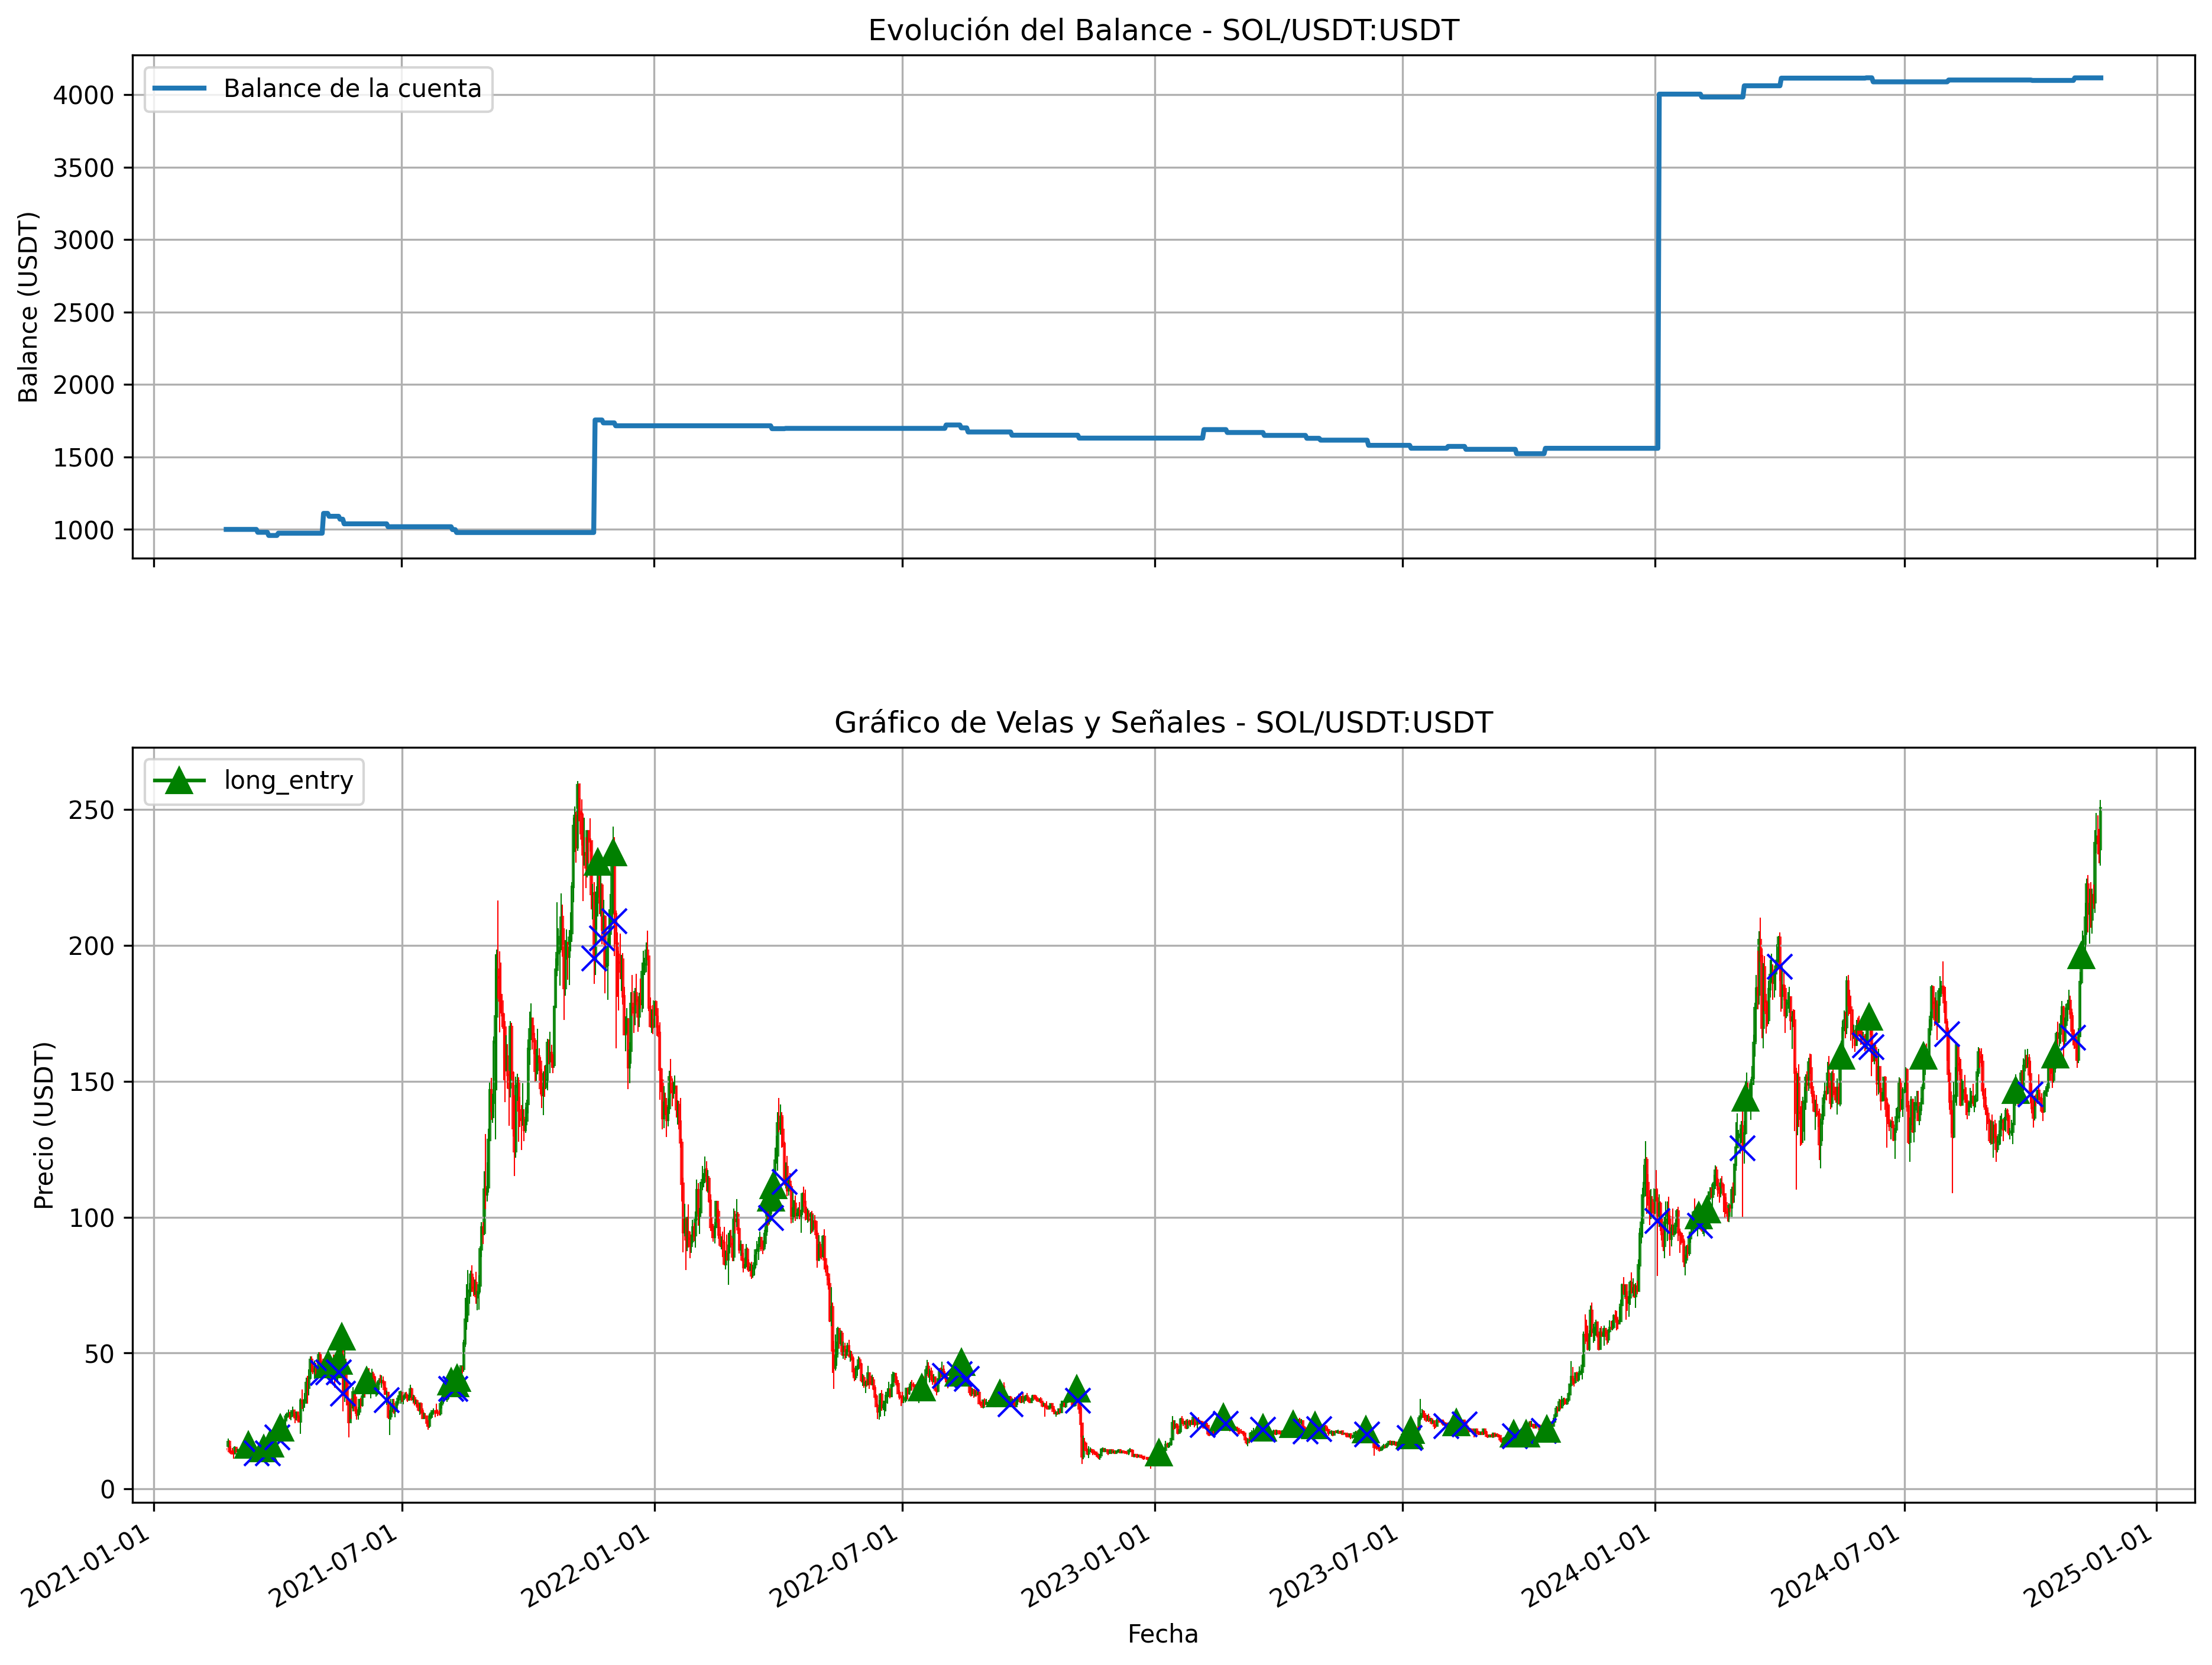

In [26]:
import openpyxl
from openpyxl.drawing.image import Image
from openpyxl.styles import Font, Alignment, Border, Side, PatternFill, NamedStyle, numbers
from openpyxl.utils.dataframe import dataframe_to_rows
import matplotlib.pyplot as plt
import matplotlib.dates as mpdates
import io
import pandas as pd
import numpy as np

def save_trading_report_to_excel(trades_df, balance_history, df, asset, monthly_returns):
    """
    Genera un archivo Excel con plots, métricas y datos de trading
    """
    # Crear workbook y hojas
    wb = openpyxl.Workbook()

    monto_fijo_resumen="monto_fijo_resumen"
    # Hoja de Resumen
    ws_summary = wb.active
    ws_summary.title = f"Resumen {monto_fijo_resumen}"

    # Definir estilos
    header_font = Font(bold=True, size=12)
    border_style = Border(
        left=Side(style='thin'),
        right=Side(style='thin'),
        top=Side(style='thin'),
        bottom=Side(style='thin')
    )
    header_fill = PatternFill(start_color="D3D3D3", end_color="D3D3D3", fill_type="solid")

    # Métricas principales
    metrics = calculate_trade_metrics(trades_df, balance_history)

    summary_metrics = [
        ["Métrica", "Valor"],
        ["Balance Inicial", f"{initial_balance} USDT"],
        ["Balance Final", f"{balance_history[-1]:.2f} USDT"],
        ["Retorno Total", f"{((balance_history[-1] - initial_balance) / initial_balance * 100):.2f}%"],
        ["Máximo Drawdown", f"{metrics['max_drawdown']:.2f}%"],
        ["Máxima Operación Ganadora", f"${metrics['max_profit_amount']:.2f}"],
        ["Ganancia Promedio", f"${metrics['avg_profit_amount']:.2f}"],
        ["Pérdida Promedio", f"${metrics['avg_loss_amount']:.2f}"],
        ["Total de operaciones", f"{total_trades:.2f}"],
        ["Winrate", f"%{win_rate:.2f}"]
    ]

    # Escribir métricas de resumen
    for row_idx, row_data in enumerate(summary_metrics, start=1):
        for col_idx, value in enumerate(row_data, start=1):
            cell = ws_summary.cell(row=row_idx, column=col_idx, value=value)
            cell.border = border_style
            if row_idx == 1:
                cell.font = header_font
                cell.fill = header_fill

    # Hoja de Historial de Trades
    ws_trades = wb.create_sheet(title="Historial de Trades")

    # Generar historial de trading con función existente
    history_df = generate_trading_history(trades_df)

    # Crear estilo para fechas
    date_style = NamedStyle(name='datetime')
    date_style.number_format = 'DD/MM/YYYY'

    # Escribir historial de trades
    for row_idx, column_name in enumerate(history_df.columns, start=1):
        ws_trades.cell(row=1, column=row_idx, value=column_name).font = header_font

    for row_idx, row_data in enumerate(history_df.values.tolist(), start=2):
        for col_idx, value in enumerate(row_data, start=1):
            cell = ws_trades.cell(row=row_idx, column=col_idx, value=value)

            # Aplicar estilo de fecha para columnas de fecha
            if isinstance(value, pd.Timestamp):
                cell.style = date_style

            # Formatear columnas numéricas
            if isinstance(value, (int, float)):
                if 'Precio' in history_df.columns[col_idx-1] or 'PnL' in history_df.columns[col_idx-1] or 'Retorno' in history_df.columns[col_idx-1]:
                    cell.number_format = '0.00'
                elif 'Volumen' in history_df.columns[col_idx-1]:
                    cell.number_format = '0.00'

    # Hoja de Retornos Mensuales
    ws_monthly = wb.create_sheet(title="Retornos Mensuales")

    for row_idx, column_name in enumerate(monthly_returns.columns, start=1):
        ws_monthly.cell(row=1, column=row_idx, value=column_name).font = header_font

    for row_idx, row_data in enumerate(monthly_returns.values.tolist(), start=2):
        for col_idx, value in enumerate(row_data, start=1):
            cell = ws_monthly.cell(row=row_idx, column=col_idx, value=value)

            # Aplicar estilo de fecha para columnas de fecha
            if isinstance(value, pd.Timestamp):
                cell.style = date_style

            # Formatear columnas numéricas
            if isinstance(value, (int, float)):
                if 'Retorno' in monthly_returns.columns[col_idx-1]:
                    cell.number_format = '0.00'

    # Generar plots y guardar en Excel
    plt.close('all')  # Cerrar cualquier figura existente

    # Configuración para alta calidad de imagen
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300

    # Recrear la figura con configuraciones para alta calidad
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), height_ratios=[1, 1.5])
    plt.subplots_adjust(hspace=0.3)

    # Subplot 1: Evolución del balance
    dates = df['timestamp'].values
    balance_dates = dates[:len(balance_history)]  # Usar las fechas correspondientes
    ax1.plot(balance_dates, balance_history, label='Balance de la cuenta', linewidth=2)
    ax1.set_title(f'Evolución del Balance - {asset}')
    ax1.set_xlabel('Fecha')
    ax1.set_ylabel('Balance (USDT)')
    ax1.grid(True)
    ax1.legend()

    # Formatear fechas en el eje x
    ax1.xaxis.set_major_formatter(mpdates.DateFormatter('%Y-%m-%d'))
    ax1.xaxis.set_major_locator(mpdates.AutoDateLocator())

    # Subplot 2: Gráfico de velas y señales
    # Preparar datos para el gráfico de velas
    df_ohlc = df[['timestamp', 'open', 'high', 'low', 'close']].copy()
    df_ohlc['timestamp'] = df_ohlc['timestamp'].map(mpdates.date2num)

    # Dibujar velas japonesas
    from mplfinance.original_flavor import candlestick_ohlc
    candlestick_ohlc(ax2, df_ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)

    # Añadir señales de entrada y salida
    for _, trade in trades_df.iterrows():
        date = mpdates.date2num(trade['date'])
        if 'entry' in trade['type']:
            marker = '^' if 'long' in trade['type'] else 'v'
            color = 'g' if 'long' in trade['type'] else 'r'
            ax2.plot(date, trade['price'], marker=marker, color=color, markersize=10, label=trade['type'])
        elif 'exit' in trade['type'] or 'stop' in trade['type']:
            marker = 'x'
            color = 'blue'
            ax2.plot(date, trade['price'], marker=marker, color=color, markersize=10)

    # Configurar el gráfico de velas
    ax2.set_title(f'Gráfico de Velas y Señales - {asset}')
    ax2.set_xlabel('Fecha')
    ax2.set_ylabel('Precio (USDT)')
    ax2.grid(True)
    ax2.xaxis.set_major_formatter(mpdates.DateFormatter('%Y-%m-%d'))
    ax2.xaxis.set_major_locator(mpdates.AutoDateLocator())

    # Añadir leyenda sin duplicados
    handles, labels = ax2.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax2.legend(by_label.values(), by_label.keys())

    # Rotar etiquetas de fecha para mejor visualización
    plt.gcf().autofmt_xdate()

    # Guardar imagen en alta calidad
    img_buffer = io.BytesIO()
    plt.savefig(img_buffer, format='png', dpi=300, bbox_inches='tight')
    img_buffer.seek(0)

    # Agregar imagen al Excel
    img = Image(img_buffer)
    img.width = 800
    img.height = 600
    ws_summary.add_image(img, 'E2')

    # Ajustar anchos de columna
    for sheet in [ws_summary, ws_trades, ws_monthly]:
        for col in sheet.columns:
            max_length = 0
            column = col[0].column_letter
            for cell in col:
                try:
                    if len(str(cell.value)) > max_length:
                        max_length = len(cell.value)
                except:
                    pass
            adjusted_width = (max_length + 2)
            sheet.column_dimensions[column].width = adjusted_width

    # Guardar archivo
    filename = f'monto_fijo_resumen.xlsx'
    wb.save(filename)
    print(f"Archivo {filename} generado exitosamente.")

# Llamada de ejemplo (ajusta con tus variables globales)
save_trading_report_to_excel(trades_df, balance_history, df, asset, monthly_returns)

# **#  F de Kelly backtest**

**Configuracion de F de Kelly**

In [27]:
factor_kelly_diluido=5 # recomedado del 5 al 10, un valor de 1 seria la F de Kelly pura que representa un riesgo demasiado elevado
assets = ['SOL/USDT:USDT'] #Solo cambiar el nombre de la cryptomoneda antes del /
initial_balance = 1000 # Balance inicial de la cuenta



start_date = datetime.datetime(2021, 1, 1) # Fecha de inicio del backtest
end_date = datetime.datetime.now() # Fecha Final del backtest


Analizando SOL/USDT:USDT

Resultados aplicando la Fracción de Kelly (7.65% de riesgo):
Balance Final: 20450.07 USDT
Retorno Total: 1945.01%

Métricas Detalladas:
Máximo Drawdown: 62.41%
Máxima operacion ganadora en $: $12863.47)

Promedios:
Ganancia promedio: $1887.62 
Pérdida promedio: $-268.33


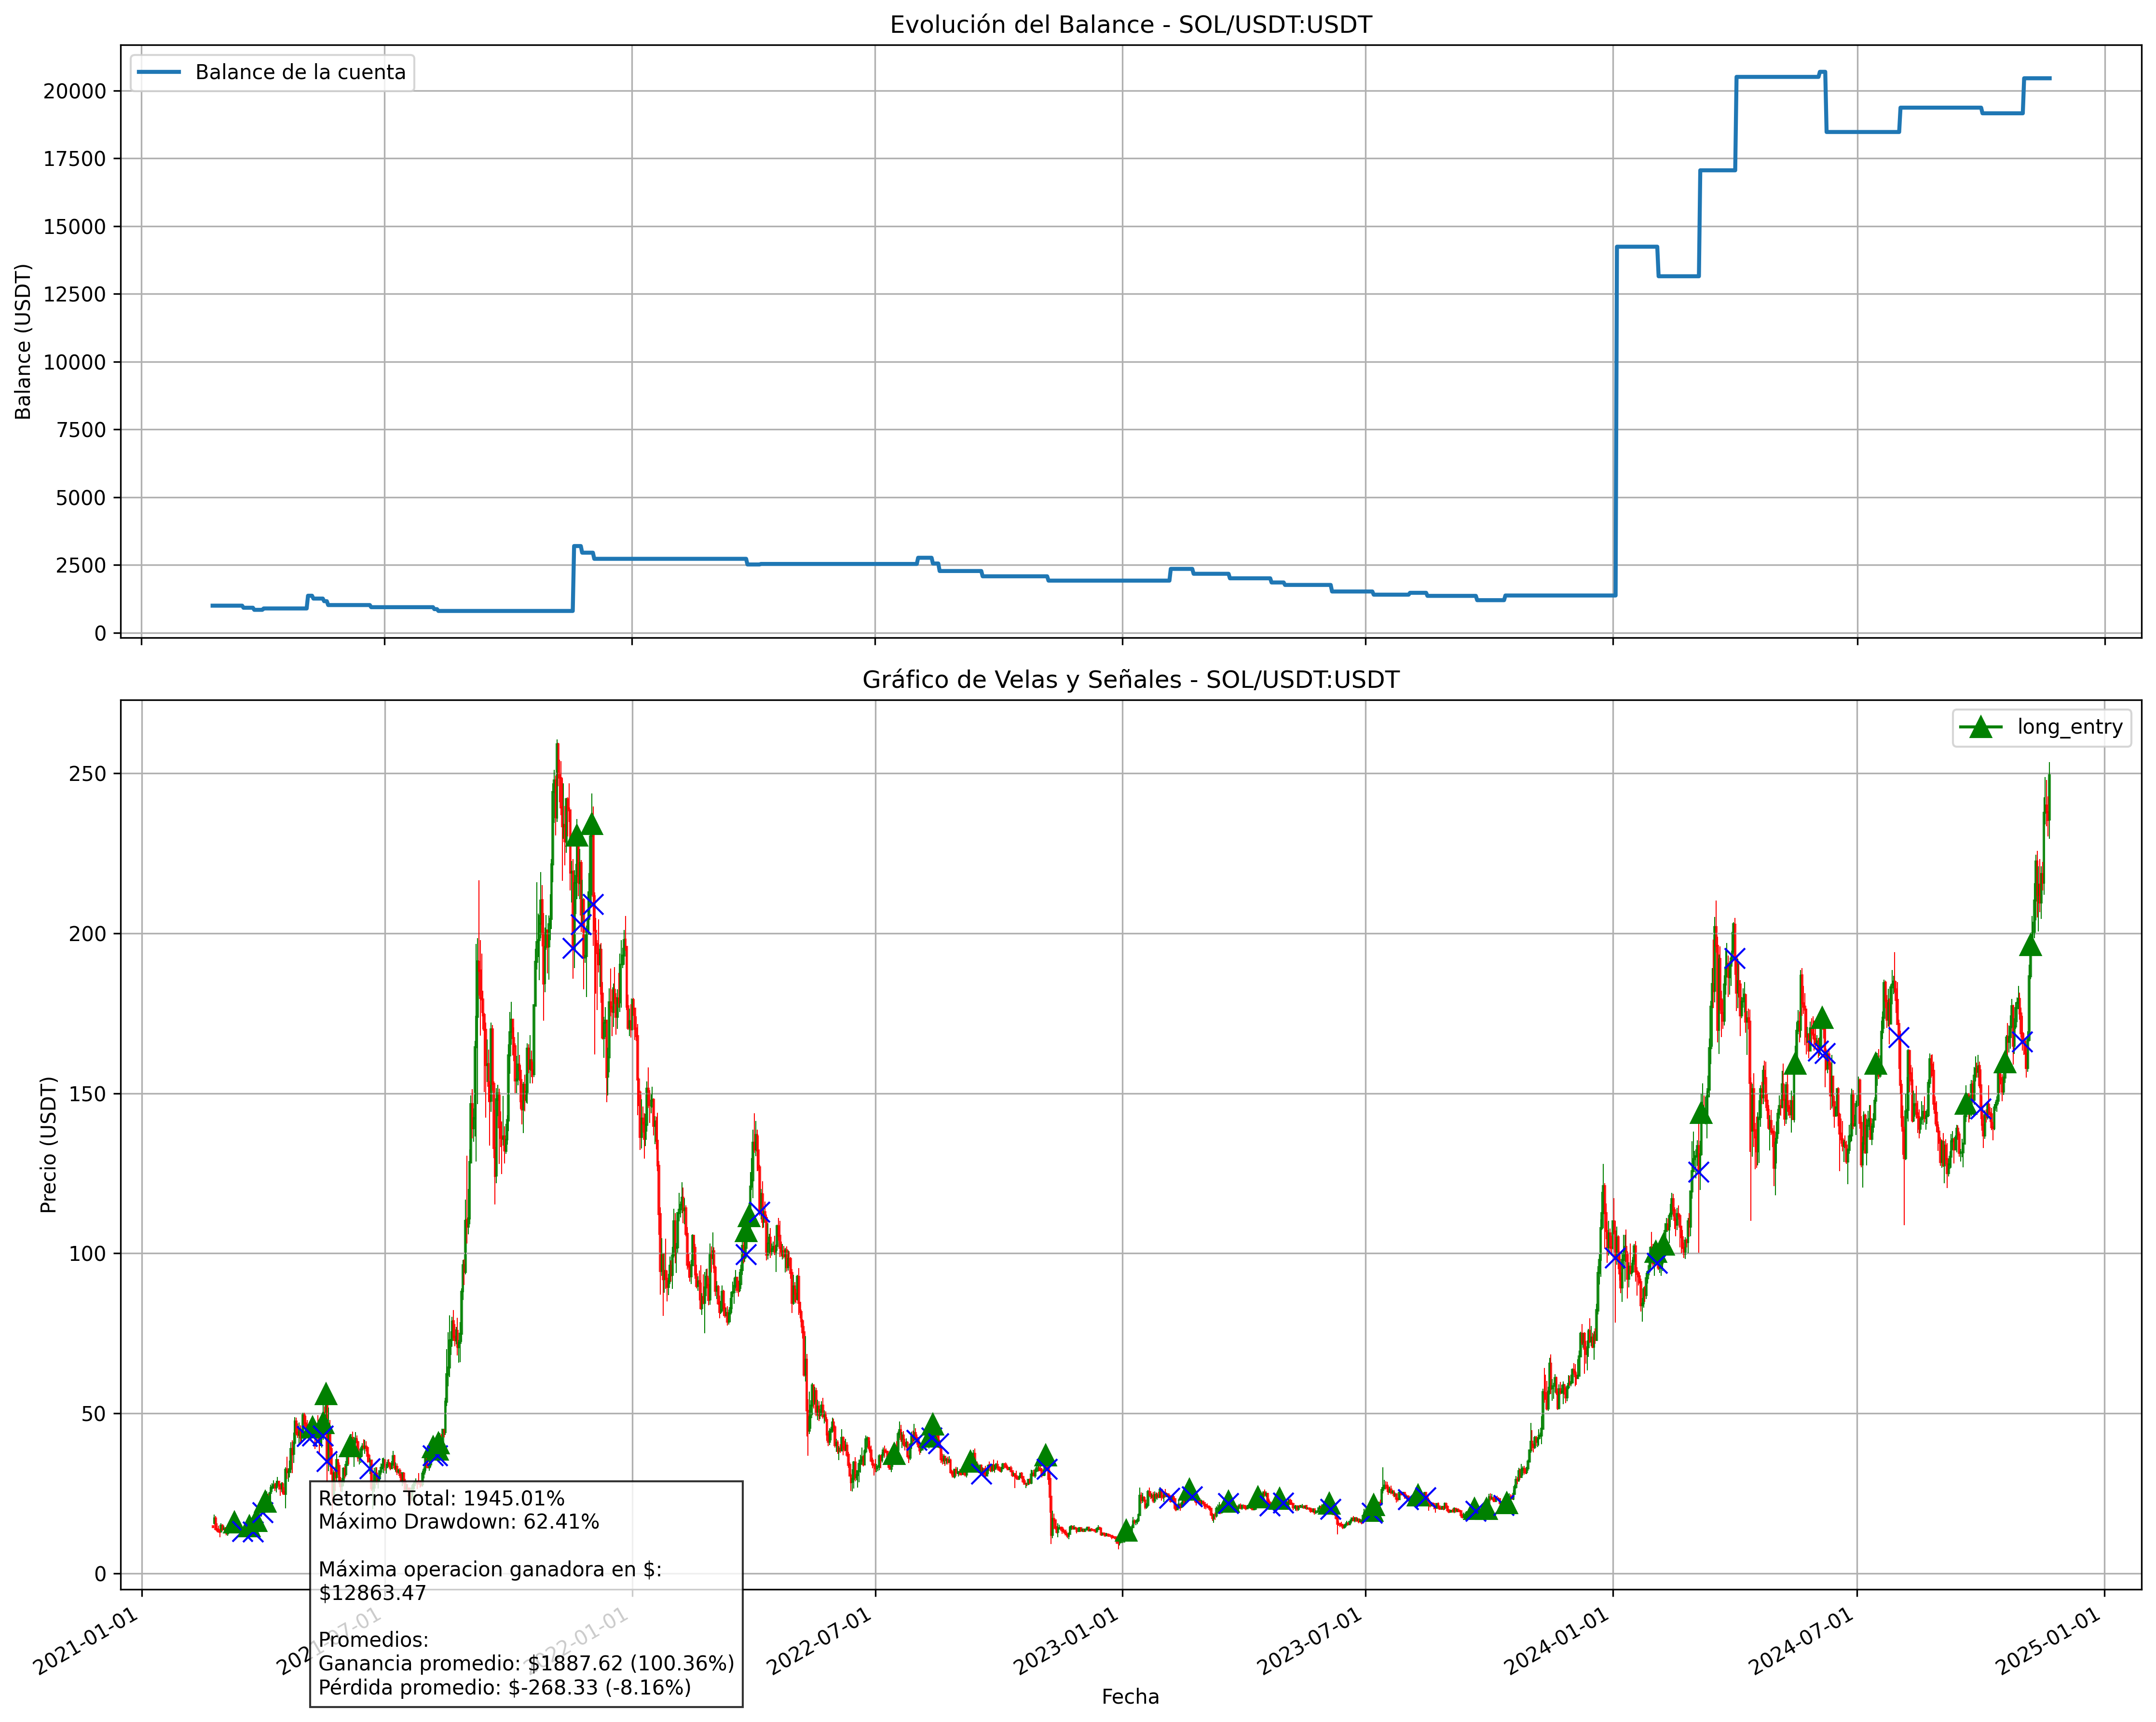


=== HISTORIAL DETALLADO DE OPERACIONES ===
   Fecha Entrada Fecha Salida  Tipo  Tipo Salida  Precio Entrada  Precio Salida  Volumen Asset  \
0     2021-03-11   2021-03-17  LONG    Stop Loss          16.044         13.163      26.570444   
1     2021-03-22   2021-03-25  LONG  Take Profit          14.824         13.010      42.558477   
2     2021-03-27   2021-04-01  LONG  Take Profit          16.480         19.080      19.529675   
3     2021-04-03   2021-05-04  LONG  Take Profit          22.440         42.770      23.089070   
4     2021-05-08   2021-05-08  LONG    Stop Loss          45.734         42.901      36.921732   
5     2021-05-16   2021-05-16  LONG    Stop Loss          47.034         42.901      23.370977   
6     2021-05-18   2021-05-19  LONG  Take Profit          56.024         35.009       6.797086   
7     2021-06-05   2021-06-20  LONG    Stop Loss          39.858         32.656      10.866951   
8     2021-08-06   2021-08-06  LONG    Stop Loss          39.492         3

In [28]:
from datetime import timedelta
timeframe = '1d'
exchange = ccxt.kucoinfutures()
markets = exchange.load_markets()
global_balance = initial_balance
short_trades = 0
long_trades = 0
short_trades_1 = 0
long_trades_1 = 0

# Variables iniciales
initial_balance = 1000
risk_percentage_value=2 #% del riesgo en primera entrada




def calculate_position_size(capital, risk_percentage, entry_price, stop_loss):
    """
    Calcula el tamaño de la posición basado en parámetros de riesgo
    """
    risk_amount = capital * (risk_percentage / 100)
    price_distance = abs(entry_price - stop_loss)
    if price_distance == 0:
        return 0
    position_size = risk_amount / price_distance
    return position_size

def get_ohlcv(symbol, timeframe, since, limit):
    """
    Obtiene datos OHLCV del exchange
    """
    return exchange.fetch_ohlcv(symbol, timeframe, since, limit)

def calculate_trade_metrics(trades_df, balance_history):
    """
    Calcula métricas detalladas de trading
    """
    # Calcular drawdown
    peak = balance_history[0]
    drawdowns = []
    for balance in balance_history:
        if balance > peak:
            peak = balance
        drawdown = (peak - balance) / peak * 100
        drawdowns.append(drawdown)
    max_drawdown = max(drawdowns)

    # Filtrar trades cerrados (exits y stops)
    closed_trades = trades_df[trades_df['type'].str.contains('exit|stop')].copy()

    # Calcular PnL por trade
    closed_trades.loc[:, 'pnl_percentage'] = closed_trades['pnl'] / (closed_trades['balance'] - closed_trades['pnl']) * 100

    # Máxima ganancia
    if not closed_trades.empty:
        max_profit_trade = closed_trades.loc[closed_trades['pnl'].idxmax()]
        max_profit_amount = max_profit_trade['pnl']
        max_profit_percentage = max_profit_trade['pnl_percentage']
    else:
        max_profit_amount = 0
        max_profit_percentage = 0

    # Promedio de ganancias y pérdidas
    winning_trades = closed_trades[closed_trades['pnl'] > 0]
    losing_trades = closed_trades[closed_trades['pnl'] < 0]

    avg_profit_amount = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
    avg_loss_amount = losing_trades['pnl'].mean() if len(losing_trades) > 0 else 0
    avg_profit_percentage = winning_trades['pnl_percentage'].mean() if len(winning_trades) > 0 else 0
    avg_loss_percentage = losing_trades['pnl_percentage'].mean() if len(losing_trades) > 0 else 0

    return {
        'max_drawdown': max_drawdown,
        'max_profit_amount': max_profit_amount,
        'max_profit_percentage': max_profit_percentage,
        'avg_profit_amount': avg_profit_amount,
        'avg_loss_amount': avg_loss_amount,
        'avg_profit_percentage': avg_profit_percentage,
        'avg_loss_percentage': avg_loss_percentage
    }

def backtest_strategy(df, initial_balance=initial_balance, risk_percentage=risk_percentage_value):
    """
    Ejecuta el backtest de la estrategia con gestión de posición
    """
    balance = initial_balance
    positions = []
    balance_history = [initial_balance]
    position_active = False
    current_position = None

    for i in range(1, len(df)):
        if df['rsi'].iloc[i] is None:
            continue

        balance_history.append(balance)

        # Gestión de salidas de posiciones existentes
        if position_active and current_position is not None:
            if current_position['type'] == 'long' and df['close_long'].iloc[i]:
                exit_price = df['close'].iloc[i]
                pnl = (exit_price - current_position['entry_price']) * current_position['size']
                balance += pnl
                position_active = False
                positions.append({
                    'type': 'long_exit',
                    'date': df['timestamp'].iloc[i],
                    'price': exit_price,
                    'balance': balance,
                    'pnl': pnl
                })

            elif current_position['type'] == 'short' and df['close_short'].iloc[i]:
                exit_price = df['close'].iloc[i]
                pnl = (current_position['entry_price'] - exit_price) * current_position['size']
                balance += pnl
                position_active = False
                positions.append({
                    'type': 'short_exit',
                    'date': df['timestamp'].iloc[i],
                    'price': exit_price,
                    'balance': balance,
                    'pnl': pnl
                })

        # Entradas de nuevas posiciones
        if not position_active:
            if df['long_condition'].iloc[i]:
                entry_price = df['close'].iloc[i]
                stop_loss = df['close_monthly'].iloc[i]
                position_size = calculate_position_size(balance, risk_percentage, entry_price, stop_loss)

                current_position = {
                    'type': 'long',
                    'entry_price': entry_price,
                    'stop_loss': stop_loss,
                    'size': position_size
                }
                position_active = True

                positions.append({
                    'type': 'long_entry',
                    'date': df['timestamp'].iloc[i],
                    'price': entry_price,
                    'size': position_size,
                    'balance': balance
                })

            elif df['short_condition'].iloc[i]:
                entry_price = df['close'].iloc[i]
                stop_loss = df['close_monthly'].iloc[i]
                position_size = calculate_position_size(balance, risk_percentage, entry_price, stop_loss)

                current_position = {
                    'type': 'short',
                    'entry_price': entry_price,
                    'stop_loss': stop_loss,
                    'size': position_size
                }
                position_active = True

                positions.append({
                    'type': 'short_entry',
                    'date': df['timestamp'].iloc[i],
                    'price': entry_price,
                    'size': position_size,
                    'balance': balance
                })

        # Verificación de stop loss
        if position_active and current_position is not None:
            if current_position['type'] == 'long' and df['low'].iloc[i] <= current_position['stop_loss']:
                exit_price = current_position['stop_loss']
                pnl = (exit_price - current_position['entry_price']) * current_position['size']
                balance += pnl
                position_active = False
                positions.append({
                    'type': 'long_stop',
                    'date': df['timestamp'].iloc[i],
                    'price': exit_price,
                    'balance': balance,
                    'pnl': pnl
                })

            elif current_position['type'] == 'short' and df['high'].iloc[i] >= current_position['stop_loss']:
                exit_price = current_position['stop_loss']
                pnl = (current_position['entry_price'] - exit_price) * current_position['size']
                balance += pnl
                position_active = False
                positions.append({
                    'type': 'short_stop',
                    'date': df['timestamp'].iloc[i],
                    'price': exit_price,
                    'balance': balance,
                    'pnl': pnl
                })

    return pd.DataFrame(positions), balance_history

def plot_balance_evolution(df_trades, balance_history, df, asset):
    """
    Genera dos subplots: evolución del balance y gráfico de velas con señales
    """
    metrics = calculate_trade_metrics(df_trades, balance_history)

    # Crear figura con dos subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), height_ratios=[1, 1.5])
    plt.subplots_adjust(hspace=0.3)

    # Subplot 1: Evolución del balance
    dates = df['timestamp'].values
    balance_dates = dates[:len(balance_history)]  # Usar las fechas correspondientes
    ax1.plot(balance_dates, balance_history, label='Balance de la cuenta', linewidth=2)
    ax1.set_title(f'Evolución del Balance - {asset}')
    ax1.set_xlabel('Fecha')
    ax1.set_ylabel('Balance (USDT)')
    ax1.grid(True)
    ax1.legend()

    # Formatear fechas en el eje x
    ax1.xaxis.set_major_formatter(mpdates.DateFormatter('%Y-%m-%d'))
    ax1.xaxis.set_major_locator(mpdates.AutoDateLocator())

    # Subplot 2: Gráfico de velas y señales
    # Preparar datos para el gráfico de velas
    df_ohlc = df[['timestamp', 'open', 'high', 'low', 'close']].copy()
    df_ohlc['timestamp'] = df_ohlc['timestamp'].map(mpdates.date2num)

    # Dibujar velas japonesas
    candlestick_ohlc(ax2, df_ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)

    # Añadir señales de entrada y salida
    for _, trade in df_trades.iterrows():
        date = mpdates.date2num(trade['date'])
        if 'entry' in trade['type']:
            marker = '^' if 'long' in trade['type'] else 'v'
            color = 'g' if 'long' in trade['type'] else 'r'
            ax2.plot(date, trade['price'], marker=marker, color=color, markersize=10, label=trade['type'])
        elif 'exit' in trade['type'] or 'stop' in trade['type']:
            marker = 'x'
            color = 'blue'
            ax2.plot(date, trade['price'], marker=marker, color=color, markersize=10)

    # Configurar el gráfico de velas
    ax2.set_title(f'Gráfico de Velas y Señales - {asset}')
    ax2.set_xlabel('Fecha')
    ax2.set_ylabel('Precio (USDT)')
    ax2.grid(True)
    ax2.xaxis.set_major_formatter(mpdates.DateFormatter('%Y-%m-%d'))
    ax2.xaxis.set_major_locator(mpdates.AutoDateLocator())

    # Añadir leyenda sin duplicados
    handles, labels = ax2.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax2.legend(by_label.values(), by_label.keys())

    # Rotar etiquetas de fecha para mejor visualización
    plt.gcf().autofmt_xdate()

    # Texto con métricas
    metrics_text = (
        f'Retorno Total: {((balance_history[-1] - balance_history[0]) / balance_history[0] * 100):.2f}%\n'
        f'Máximo Drawdown: {metrics["max_drawdown"]:.2f}%\n'
        f'\nMáxima operacion ganadora en $:\n'
        f'${metrics["max_profit_amount"]:.2f}\n'
        f'\nPromedios:\n'
        f'Ganancia promedio: ${metrics["avg_profit_amount"]:.2f} ({metrics["avg_profit_percentage"]:.2f}%)\n'
        f'Pérdida promedio: ${metrics["avg_loss_amount"]:.2f} ({metrics["avg_loss_percentage"]:.2f}%)'
    )

    # Añadir texto con métricas
    plt.figtext(0.15, 0.02, metrics_text,
                bbox=dict(facecolor='white', alpha=0.8),
                fontsize=10)

    plt.tight_layout()
    plt.show()

# Ejecución principal
for asset in assets:
    print(f"\nAnalizando {asset}")

    try:
        # Preparación de datos
        df = pd.DataFrame()
        os.makedirs(f'kucoin_{asset}', exist_ok=True)
        symbol = asset

        # Obtención de datos históricos
        current_date = start_date
        while current_date <= end_date:
            timestamp = int(current_date.timestamp() * 1000)
            ohlcv = get_ohlcv(symbol, timeframe, timestamp, 200)
            data = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
            df = pd.concat([df, data], ignore_index=True)
            current_date += datetime.timedelta(days=200)

        # Procesamiento de datos
        df.set_index('timestamp', inplace=True)
        df['year'] = df.index.year
        df['month'] = df.index.month

        # Cálculo del cierre mensual
        first_day_open = df.groupby(['year', 'month'])['open'].first()
        first_day_open = first_day_open.reset_index()
        first_day_open['timestamp'] = pd.to_datetime(first_day_open[['year', 'month']].astype(str).apply(lambda x: '-'.join(x), axis=1))
        first_day_open['month'] = first_day_open['month']

        df = df.merge(first_day_open, on=['year', 'month', 'timestamp'], how='left')
        df = df.rename(columns={'open_x': 'open', 'open_y': 'close_monthly'})
        df['close_monthly'] = df['close_monthly'].ffill()
        df = df.drop(columns=['year', 'month'])
        df.reset_index(inplace=True)

        # Cálculo de indicadores
        df['rsi'] = ta.rsi(close=df['close'], length=14)
        df['sma100'] = ta.sma(df['close'], length=100)
        df['close_long'] = df['close'] < df['close_monthly']
        df['close_short'] = df['close'] > df['close_monthly']

        # Condiciones de entrada
        # Condiciones de entrada
        df['long_condition'] = (
            (df['close'] > df['open']) &
            (df['open'] > df['close_monthly']) &
            (df['close'].shift(1) > df['close_monthly']) &
            (df['rsi'].shift(1) > 50))

        df['short_condition'] = (
            (df['close'] > df['sma100']) &
            (df['open'] < df['close_monthly']) &
            (df['close'].shift(1) < df['close_monthly']) &
            (df['rsi'].shift(1) < 10))

        # Ejecución del backtest
        trades_df, balance_history = backtest_strategy(df, initial_balance=initial_balance, risk_percentage=risk_percentage_value)

        # Calcular métricas
        metrics = calculate_trade_metrics(trades_df, balance_history)

        # Estadísticas de trading
        profitable_trades = trades_df[trades_df['type'].str.contains('exit')]['pnl'].apply(lambda x: x > 0).sum()
        total_trades = len(trades_df[trades_df['type'].str.contains('exit|stop')])



        # Visualización de resultados
        #plot_balance_evolution(trades_df, balance_history, df, asset)

    except Exception as e:
        print(f"Error al procesar {asset}: {str(e)}")
# Calcular la fracción de Kelly
    if True:
        if total_trades > 0 and metrics['avg_loss_amount'] < 0:
            kelly_fraction = win_rate - ((1 - win_rate) / (metrics['avg_profit_amount'] / abs(metrics['avg_loss_amount'])))
            # Aplicar la fracción de Kelly diluida
            kelly_risk_percentage = kelly_fraction / factor_kelly_diluido
            trades_df_kelly, balance_history_kelly = backtest_strategy(df, initial_balance=initial_balance, risk_percentage=kelly_risk_percentage)

            print(f"\nResultados aplicando la Fracción de Kelly ({kelly_risk_percentage:.2f}% de riesgo):")
            print(f"Balance Final: {balance_history_kelly[-1]:.2f} USDT")
            print(f"Retorno Total: {((balance_history_kelly[-1] - initial_balance) / initial_balance * 100):.2f}%")

            metrics_kelly = calculate_trade_metrics(trades_df_kelly, balance_history_kelly)
            print(f"\nMétricas Detalladas:")
            print(f"Máximo Drawdown: {metrics_kelly['max_drawdown']:.2f}%")
            print(f"Máxima operacion ganadora en $: ${metrics_kelly['max_profit_amount']:.2f})")
            print(f"\nPromedios:")
            print(f"Ganancia promedio: ${metrics_kelly['avg_profit_amount']:.2f} ")
            print(f"Pérdida promedio: ${metrics_kelly['avg_loss_amount']:.2f}")

            # Visualización con Kelly
            plot_balance_evolution(trades_df_kelly, balance_history_kelly, df, asset)

import pandas as pd

def generate_trading_history(trades_df_kelly):
    """
    Genera un historial detallado de operaciones a partir del DataFrame de trades

    Parameters:
    trades_df (pd.DataFrame): DataFrame con el historial de operaciones

    Returns:
    pd.DataFrame: Historial detallado de operaciones
    """
    # Crear listas para almacenar las operaciones completas
    complete_trades = []
    current_trade = None

    for _, trade in trades_df_kelly.iterrows():
        if 'entry' in trade['type']:
            # Guardar entrada
            current_trade = {
                'entry_date': trade['date'],
                'entry_price': trade['price'],
                'position_size': trade['size'],
                'trade_type': 'LONG' if 'long' in trade['type'] else 'SHORT',
                'initial_balance': trade['balance']
            }

        elif ('exit' in trade['type'] or 'stop' in trade['type']) and current_trade is not None:
            # Completar la operación con datos de salida
            current_trade.update({
                'exit_date': trade['date'],
                'exit_price': trade['price'],
                'exit_type': 'Stop Loss' if 'stop' in trade['type'] else 'Take Profit',
                'final_balance': trade['balance'],
                'pnl': trade['pnl']
            })

            # Calcular métricas adicionales
            trade_volume_usd = current_trade['position_size'] * current_trade['entry_price']
            return_percentage = (trade['pnl'] / trade_volume_usd) * 100 if trade_volume_usd != 0 else 0

            current_trade.update({
                'trade_volume_usd': trade_volume_usd,
                'return_percentage': return_percentage
            })

            complete_trades.append(current_trade)
            current_trade = None

    # Crear DataFrame con el historial
    history_df = pd.DataFrame(complete_trades)

    # Formatear columnas
    if not history_df.empty:
        history_df = history_df.round({
            'entry_price': 4,
            'exit_price': 4,
            'position_size': 6,
            'trade_volume_usd': 2,
            'pnl': 2,
            'return_percentage': 2
        })

        # Reordenar columnas
        columns_order = [
            'entry_date', 'exit_date', 'trade_type', 'exit_type',
            'entry_price', 'exit_price', 'position_size', 'trade_volume_usd',
            'pnl', 'return_percentage', 'initial_balance', 'final_balance'
        ]
        history_df = history_df[columns_order]

        # Renombrar columnas para mejor legibilidad
        history_df.columns = [
            'Fecha Entrada', 'Fecha Salida', 'Tipo', 'Tipo Salida',
            'Precio Entrada', 'Precio Salida', 'Volumen Asset', 'Volumen USD',
            'PnL', 'Retorno %', 'Balance Inicial', 'Balance Final'
        ]

    return history_df

def print_trading_summary(history_df):
    """
    Imprime un resumen del historial de trading

    Parameters:
    history_df (pd.DataFrame): DataFrame con el historial de operaciones
    """
    if history_df.empty:
        print("No hay operaciones para analizar")
        return

    print("\n=== RESUMEN DE OPERACIONES ===")
    print(f"\nTotal de operaciones: {len(history_df)}")
    print(f"Operaciones ganadoras: {len(history_df[history_df['PnL'] > 0])}")
    print(f"Operaciones perdedoras: {len(history_df[history_df['PnL'] < 0])}")

    print(f"\nPnL total: ${history_df['PnL'].sum():.2f}")
    print(f"PnL promedio por operación: ${history_df['PnL'].mean():.2f}")
    print(f"Retorno promedio: {history_df['Retorno %'].mean():.2f}%")

    print(f"\nMejor operación: ${history_df['PnL'].max():.2f}")
    print(f"Peor operación: ${history_df['PnL'].min():.2f}")

    print(f"\nVolumen total operado: ${history_df['Volumen USD'].sum():.2f}")
    print(f"Volumen promedio por operación: ${history_df['Volumen USD'].mean():.2f}")

# Ejemplo de uso:
def analyze_trading_history(trades_df_kelly):
    """
    Analiza y muestra el historial completo de trading

    Parameters:
    trades_df (pd.DataFrame): DataFrame con las operaciones
    """
    # Generar historial detallado
    history_df = generate_trading_history(trades_df_kelly)

    # Mostrar historial completo
    if not history_df.empty:
        print("\n=== HISTORIAL DETALLADO DE OPERACIONES ===")
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        print(history_df)

        # Mostrar resumen
        #print_trading_summary(history_df)
    else:
        print("No se encontraron operaciones para analizar")

    return history_df

# Analizar el historial de operaciones
trading_history = analyze_trading_history(trades_df_kelly)

import pandas as pd

def generate_trading_history_with_monthly_returns(trades_df_kelly):
  """
  Genera un historial detallado de operaciones incluyendo retornos mensuales en dinero y porcentaje.
  """
  history_df = generate_trading_history(trades_df_kelly)

  if history_df.empty:
    return history_df, pd.DataFrame()

  history_df['Balance Mensual'] = 0.0
  history_df['Mes'] = pd.to_datetime(history_df['Fecha Entrada']).dt.to_period('M')

  balance_mensual = history_df['Balance Inicial'].iloc[0]
  for index, row in history_df.iterrows():
    balance_mensual += row['PnL']
    history_df.loc[index, 'Balance Mensual'] = balance_mensual

  monthly_returns = history_df.groupby('Mes')['Balance Mensual'].last().reset_index()
  monthly_returns['Mes'] = monthly_returns['Mes'].dt.to_timestamp()

  monthly_returns['Retorno Mensual $'] = 0.0
  monthly_returns['Retorno Mensual %'] = 0.0
  balance_anterior = history_df['Balance Inicial'].iloc[0]

  for index, row in monthly_returns.iterrows():
    if index == 0:
      retorno_dinero = row['Balance Mensual'] - balance_anterior
      retorno_porcentaje = (retorno_dinero / balance_anterior) * 100
    else:
      retorno_dinero = row['Balance Mensual'] - monthly_returns['Balance Mensual'].iloc[index - 1]
      retorno_porcentaje = (retorno_dinero / monthly_returns['Balance Mensual'].iloc[index - 1]) * 100

    monthly_returns.loc[index, 'Retorno Mensual $'] = retorno_dinero
    monthly_returns.loc[index, 'Retorno Mensual %'] = retorno_porcentaje

  return history_df, monthly_returns

# Ejemplo de uso (necesitarás crear un DataFrame trades_df)
# Supongamos que tienes un DataFrame llamado 'trades_df' con tus datos de trading
# trades_df = ... # Tu DataFrame aquí

history_df, monthly_returns = generate_trading_history_with_monthly_returns(trades_df_kelly)
# print_trading_summary(history_df)
print("\n=== Retornos Mensuales ===")
print(monthly_returns)


Archivo F_de_Kelly_resumen.xlsx generado exitosamente.


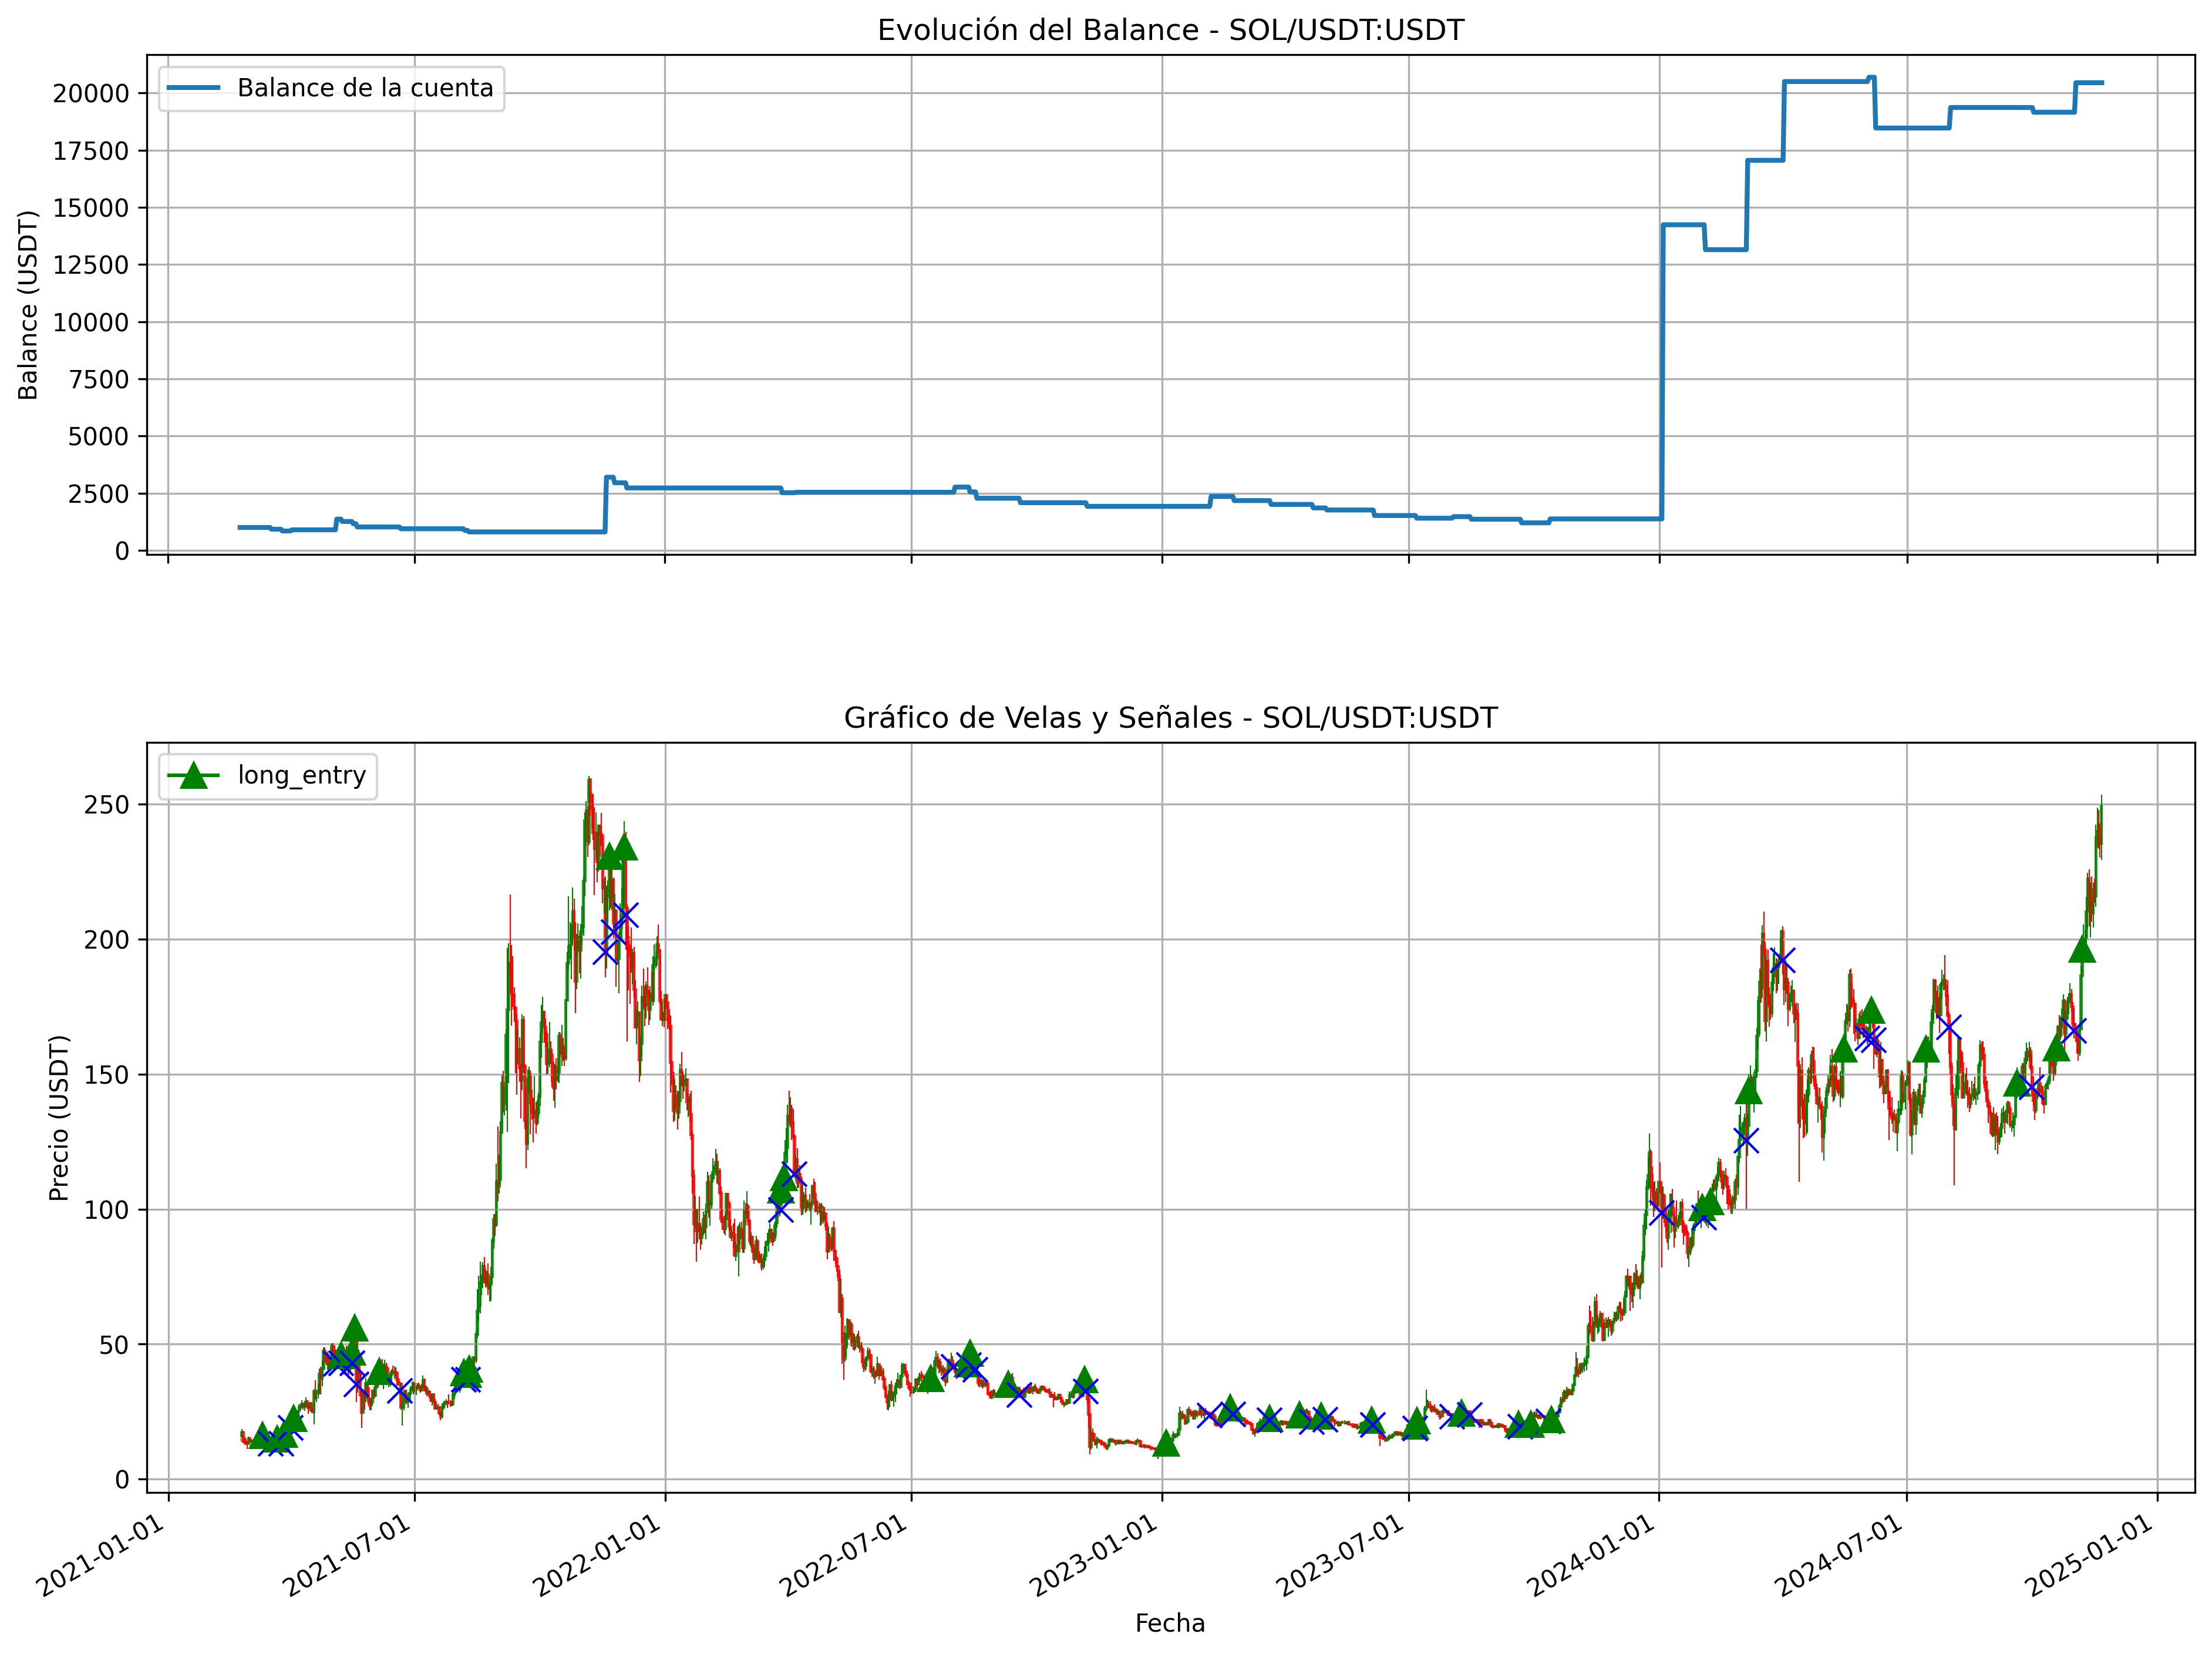

In [29]:
import openpyxl
from openpyxl.drawing.image import Image
from openpyxl.styles import Font, Alignment, Border, Side, PatternFill, NamedStyle, numbers
from openpyxl.utils.dataframe import dataframe_to_rows
import matplotlib.pyplot as plt
import matplotlib.dates as mpdates
import io
import pandas as pd
import numpy as np

def save_trading_report_to_excel(trades_df_kelly, balance_history_kelly, df, asset, monthly_returns):
    """
    Genera un archivo Excel con plots, métricas y datos de trading
    """
    # Crear workbook y hojas
    wb = openpyxl.Workbook()

    F_de_Kelly="F_de_Kelly"
    # Hoja de Resumen
    ws_summary = wb.active
    ws_summary.title = f"Resumen {F_de_Kelly}"

    # Definir estilos
    header_font = Font(bold=True, size=12)
    border_style = Border(
        left=Side(style='thin'),
        right=Side(style='thin'),
        top=Side(style='thin'),
        bottom=Side(style='thin')
    )
    header_fill = PatternFill(start_color="D3D3D3", end_color="D3D3D3", fill_type="solid")

    # Métricas principales
    metrics = calculate_trade_metrics(trades_df_kelly, balance_history_kelly)

    summary_metrics = [
        ["Métrica", "Valor"],
        ["Balance Inicial", f"{initial_balance} USDT"],
        ["Balance Final", f"{balance_history_kelly[-1]:.2f} USDT"],
        ["Retorno Total", f"{((balance_history_kelly[-1] - initial_balance) / initial_balance * 100):.2f}%"],
        ["Máximo Drawdown", f"{metrics['max_drawdown']:.2f}%"],
        ["Máxima Operación Ganadora", f"${metrics['max_profit_amount']:.2f}"],
        ["Ganancia Promedio", f"${metrics['avg_profit_amount']:.2f}"],
        ["Pérdida Promedio", f"${metrics['avg_loss_amount']:.2f}"],
        ["Total de operaciones", f"{total_trades:.2f}"],
        ["Winrate", f"%{win_rate:.2f}"],
        ["F de Kelly", f"%{kelly_risk_percentage:.2f}"]
    ]

    # Escribir métricas de resumen
    for row_idx, row_data in enumerate(summary_metrics, start=1):
        for col_idx, value in enumerate(row_data, start=1):
            cell = ws_summary.cell(row=row_idx, column=col_idx, value=value)
            cell.border = border_style
            if row_idx == 1:
                cell.font = header_font
                cell.fill = header_fill

    # Hoja de Historial de Trades
    ws_trades = wb.create_sheet(title="Historial de Trades")

    # Generar historial de trading con función existente
    history_df = generate_trading_history(trades_df_kelly)

    # Crear estilo para fechas
    date_style = NamedStyle(name='datetime')
    date_style.number_format = 'DD/MM/YYYY'

    # Escribir historial de trades
    for row_idx, column_name in enumerate(history_df.columns, start=1):
        ws_trades.cell(row=1, column=row_idx, value=column_name).font = header_font

    for row_idx, row_data in enumerate(history_df.values.tolist(), start=2):
        for col_idx, value in enumerate(row_data, start=1):
            cell = ws_trades.cell(row=row_idx, column=col_idx, value=value)

            # Aplicar estilo de fecha para columnas de fecha
            if isinstance(value, pd.Timestamp):
                cell.style = date_style

            # Formatear columnas numéricas
            if isinstance(value, (int, float)):
                if 'Precio' in history_df.columns[col_idx-1] or 'PnL' in history_df.columns[col_idx-1] or 'Retorno' in history_df.columns[col_idx-1]:
                    cell.number_format = '0.00'
                elif 'Volumen' in history_df.columns[col_idx-1]:
                    cell.number_format = '0.00'

    # Hoja de Retornos Mensuales
    ws_monthly = wb.create_sheet(title="Retornos Mensuales")

    for row_idx, column_name in enumerate(monthly_returns.columns, start=1):
        ws_monthly.cell(row=1, column=row_idx, value=column_name).font = header_font

    for row_idx, row_data in enumerate(monthly_returns.values.tolist(), start=2):
        for col_idx, value in enumerate(row_data, start=1):
            cell = ws_monthly.cell(row=row_idx, column=col_idx, value=value)

            # Aplicar estilo de fecha para columnas de fecha
            if isinstance(value, pd.Timestamp):
                cell.style = date_style

            # Formatear columnas numéricas
            if isinstance(value, (int, float)):
                if 'Retorno' in monthly_returns.columns[col_idx-1]:
                    cell.number_format = '0.00'

    # Generar plots y guardar en Excel
    plt.close('all')  # Cerrar cualquier figura existente

    # Configuración para alta calidad de imagen
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300

    # Recrear la figura con configuraciones para alta calidad
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), height_ratios=[1, 1.5])
    plt.subplots_adjust(hspace=0.3)

    # Subplot 1: Evolución del balance
    dates = df['timestamp'].values
    balance_dates = dates[:len(balance_history_kelly)]  # Usar las fechas correspondientes
    ax1.plot(balance_dates, balance_history_kelly, label='Balance de la cuenta', linewidth=2)
    ax1.set_title(f'Evolución del Balance - {asset}')
    ax1.set_xlabel('Fecha')
    ax1.set_ylabel('Balance (USDT)')
    ax1.grid(True)
    ax1.legend()

    # Formatear fechas en el eje x
    ax1.xaxis.set_major_formatter(mpdates.DateFormatter('%Y-%m-%d'))
    ax1.xaxis.set_major_locator(mpdates.AutoDateLocator())

    # Subplot 2: Gráfico de velas y señales
    # Preparar datos para el gráfico de velas
    df_ohlc = df[['timestamp', 'open', 'high', 'low', 'close']].copy()
    df_ohlc['timestamp'] = df_ohlc['timestamp'].map(mpdates.date2num)

    # Dibujar velas japonesas
    from mplfinance.original_flavor import candlestick_ohlc
    candlestick_ohlc(ax2, df_ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)

    # Añadir señales de entrada y salida
    for _, trade in trades_df_kelly.iterrows():
        date = mpdates.date2num(trade['date'])
        if 'entry' in trade['type']:
            marker = '^' if 'long' in trade['type'] else 'v'
            color = 'g' if 'long' in trade['type'] else 'r'
            ax2.plot(date, trade['price'], marker=marker, color=color, markersize=10, label=trade['type'])
        elif 'exit' in trade['type'] or 'stop' in trade['type']:
            marker = 'x'
            color = 'blue'
            ax2.plot(date, trade['price'], marker=marker, color=color, markersize=10)

    # Configurar el gráfico de velas
    ax2.set_title(f'Gráfico de Velas y Señales - {asset}')
    ax2.set_xlabel('Fecha')
    ax2.set_ylabel('Precio (USDT)')
    ax2.grid(True)
    ax2.xaxis.set_major_formatter(mpdates.DateFormatter('%Y-%m-%d'))
    ax2.xaxis.set_major_locator(mpdates.AutoDateLocator())

    # Añadir leyenda sin duplicados
    handles, labels = ax2.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax2.legend(by_label.values(), by_label.keys())

    # Rotar etiquetas de fecha para mejor visualización
    plt.gcf().autofmt_xdate()

    # Guardar imagen en alta calidad
    img_buffer = io.BytesIO()
    plt.savefig(img_buffer, format='png', dpi=300, bbox_inches='tight')
    img_buffer.seek(0)

    # Agregar imagen al Excel
    img = Image(img_buffer)
    img.width = 800
    img.height = 600
    ws_summary.add_image(img, 'E2')

    # Ajustar anchos de columna
    for sheet in [ws_summary, ws_trades, ws_monthly]:
        for col in sheet.columns:
            max_length = 0
            column = col[0].column_letter
            for cell in col:
                try:
                    if len(str(cell.value)) > max_length:
                        max_length = len(cell.value)
                except:
                    pass
            adjusted_width = (max_length + 2)
            sheet.column_dimensions[column].width = adjusted_width

    # Guardar archivo
    filename = f'F_de_Kelly_resumen.xlsx'
    wb.save(filename)
    print(f"Archivo {filename} generado exitosamente.")

# Llamada de ejemplo (ajusta con tus variables globales)
save_trading_report_to_excel(trades_df_kelly, balance_history_kelly, df, asset, monthly_returns)

# **Comparativa de tipos de gestion**

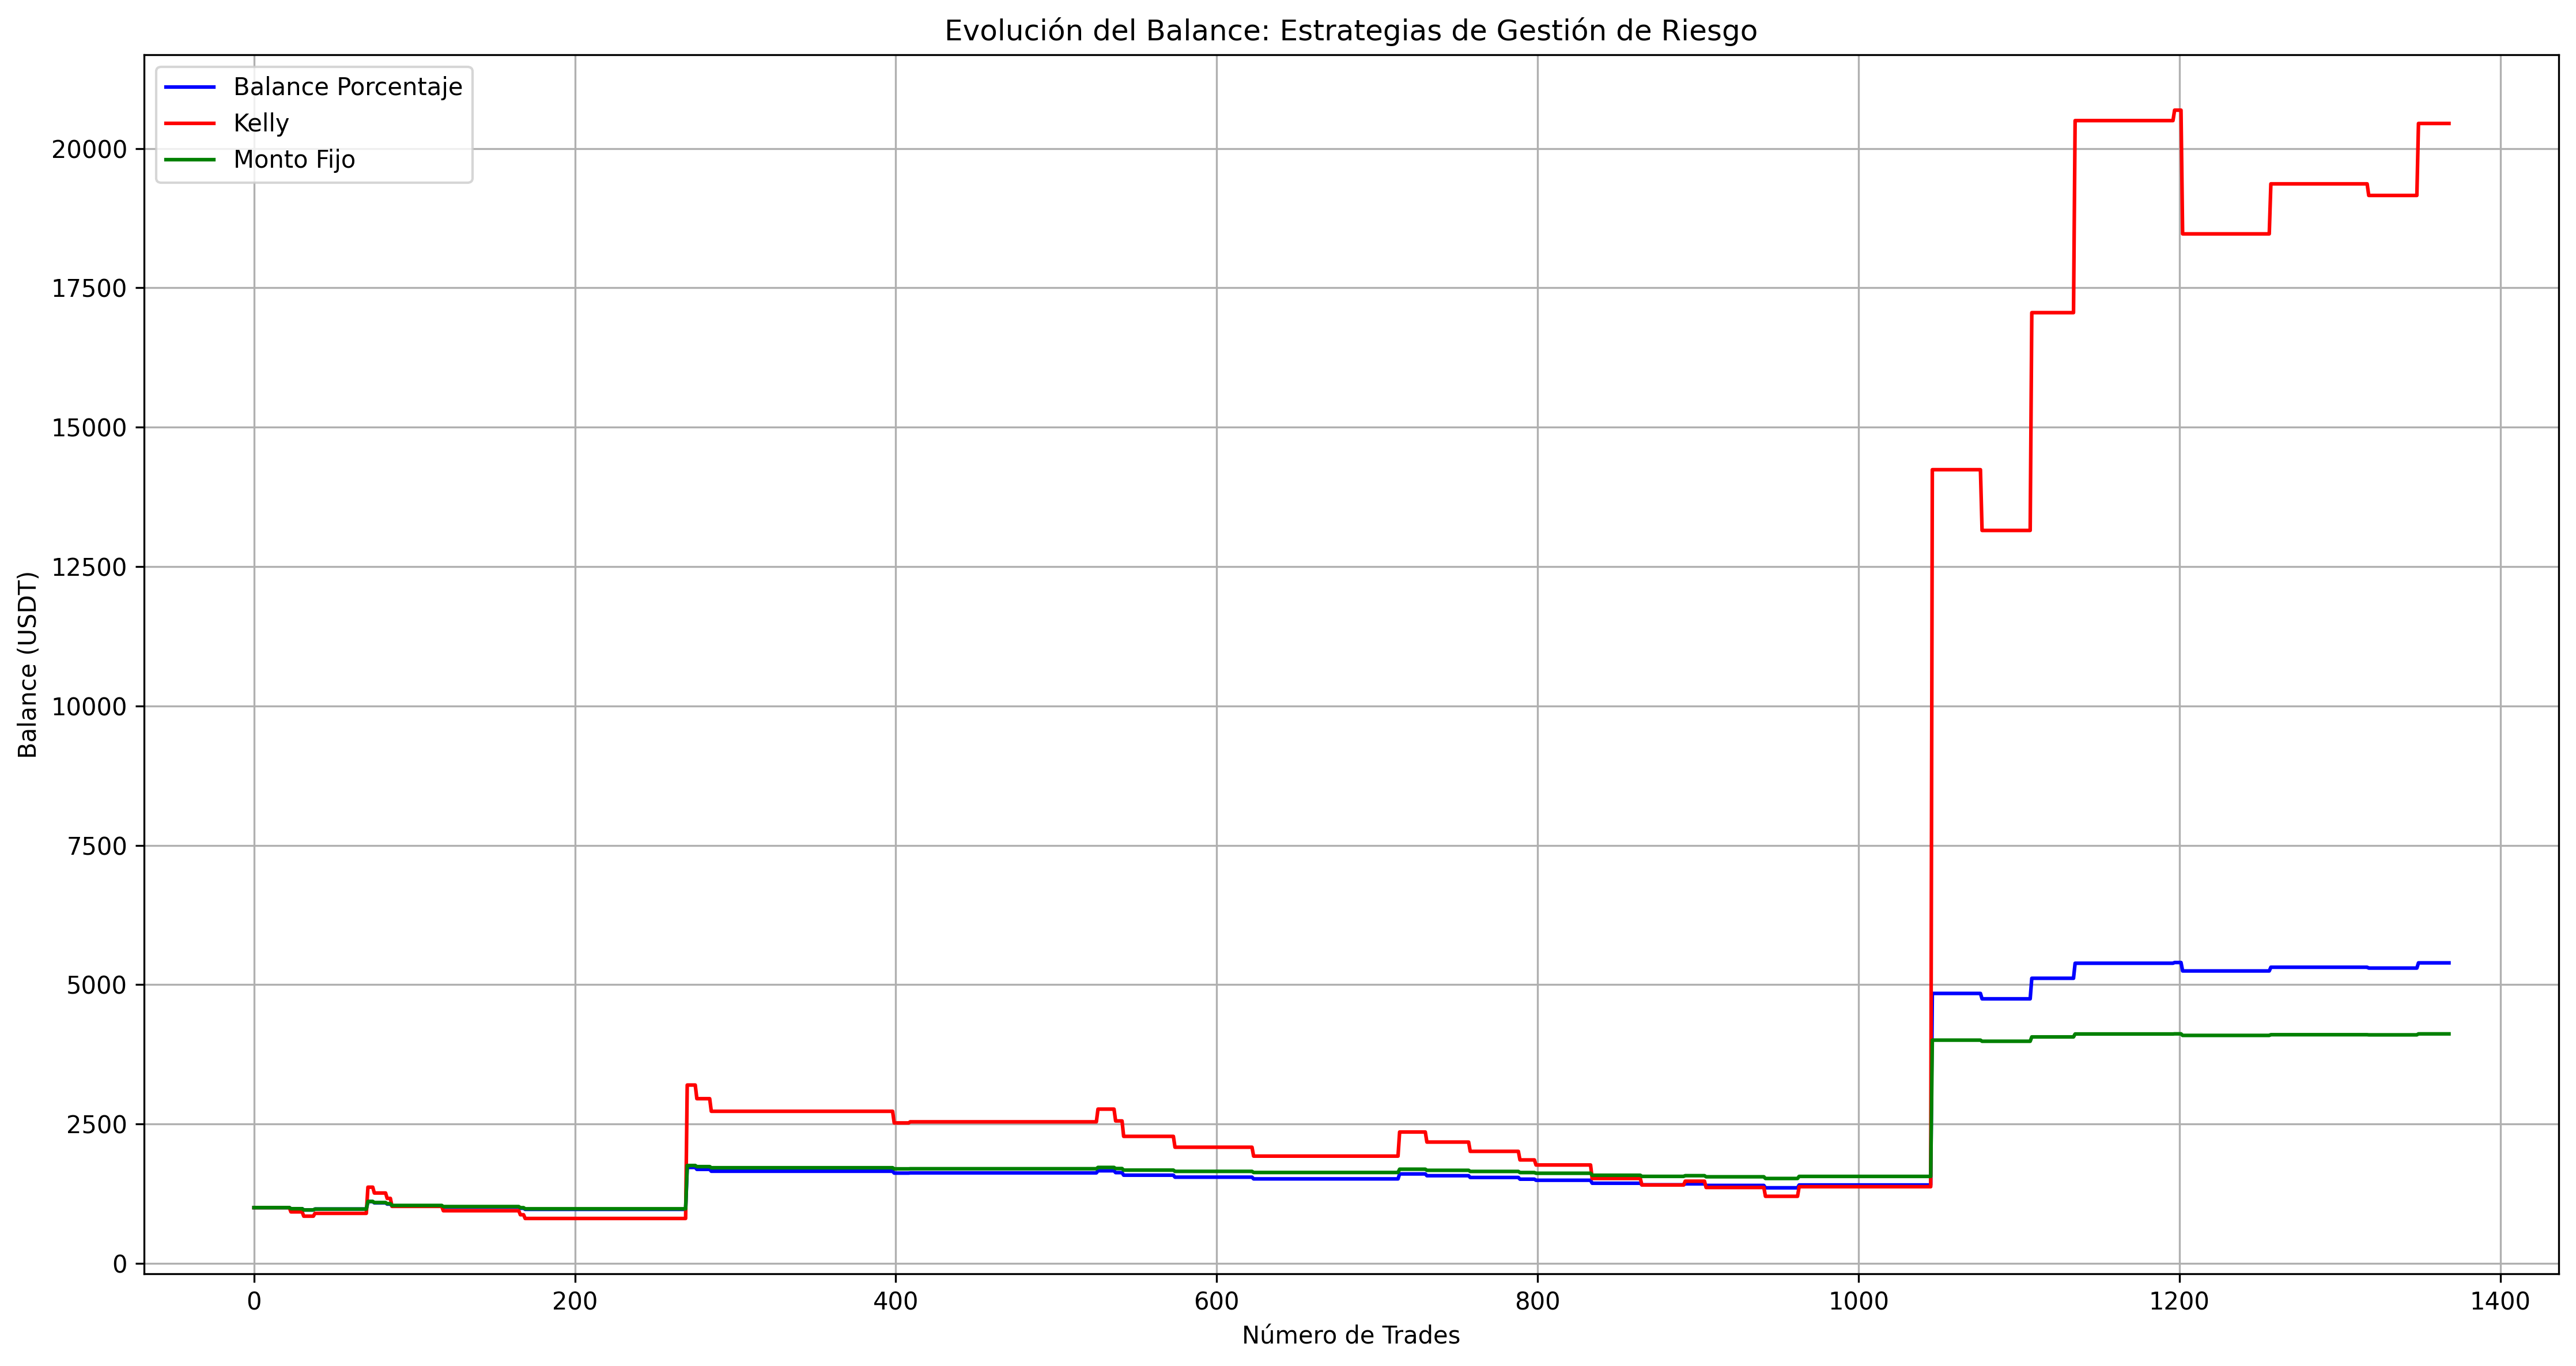


=== COMPARACIÓN DE ESTRATEGIAS ===

Metricas Generales:
                    final_balance total_return_pct max_drawdown win_rate
Balance Porcentaje        5390.44          439.04%       21.24%    35.0%
Kelly                    20450.07         1945.01%       62.41%    35.0%
Monto Fijo                4116.63          311.66%       13.27%    35.0%

Retornos Mensuales:
          Mes Retorno Mensual % (Porcentaje) Retorno Mensual % (Kelly)  \
0  2021-03-01           -2.6379999999999995%      -10.297000000000004%   
1  2021-04-01            13.671658347199115%         52.3282387434088%   
2  2021-05-01           -7.0351395552664275%      -25.177286798445575%   
3  2021-06-01            -2.000252704423304%       -7.654538341158059%   
4  2021-08-01             70.64237471362408%       238.80992225729236%   
5  2021-11-01           -1.9999186316162716%      -7.6549624238786524%   
6  2021-12-01           -1.9998102196707328%       -7.654783223932533%   
7  2022-03-01           -1.79855244365

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

def compare_risk_management_strategies(trades_df, trades_df_kelly, trades_df_fixed, initial_balance):
    """
    Compara las estrategias de gestión de riesgo: Porcentaje de Balance, Kelly, y Monto Fijo

    Parameters:
    trades_df(pd.DataFrame): Trades con gestión de riesgo por porcentaje de balance
    trades_df_kelly (pd.DataFrame): Trades con gestión de riesgo de Kelly
    trades_df_fixed (pd.DataFrame): Trades con gestión de riesgo por monto fijo
    initial_balance (float): Balance inicial

    Returns:
    dict: Resultados comparativos
    """
    def get_strategy_metrics(trades_df_t, balance_history_t):
        metrics = calculate_trade_metrics(trades_df_t, balance_history_t)
        total_return = (balance_history_t[-1] - initial_balance) / initial_balance * 100
        profitable_trades = trades_df_t[trades_df_t['type'].str.contains('exit')]['pnl'].apply(lambda x: x > 0).sum()
        total_trades = len(trades_df_t[trades_df_t['type'].str.contains('exit|stop')])
        win_rate = profitable_trades / total_trades if total_trades > 0 else 0

        return {
            'final_balance': round(balance_history_t[-1], 2),
            'total_return_pct': round(total_return, 2),
            'max_drawdown': round(metrics['max_drawdown'], 2),
            'win_rate': round(win_rate * 100, 2),
            'total_trades': total_trades,
            'avg_profit': round(metrics['avg_profit_amount'], 2),
            'avg_loss': round(metrics['avg_loss_amount'], 2)
        }

    # Preparar métricas para cada estrategia
    percentage_metrics = get_strategy_metrics(trades_df, balance_history)
    kelly_metrics = get_strategy_metrics(trades_df_kelly, balance_history_kelly)
    fixed_metrics = get_strategy_metrics(trades_df_fixed, balance_history_fixed)

    # Generar tabla comparativa con formato específico para consola y Excel
    comparison_data = {
        'final_balance': [percentage_metrics['final_balance'],
                          kelly_metrics['final_balance'],
                          fixed_metrics['final_balance']],
        'total_return_pct': [percentage_metrics['total_return_pct'],
                              kelly_metrics['total_return_pct'],
                              fixed_metrics['total_return_pct']],
        'max_drawdown': [percentage_metrics['max_drawdown'],
                         kelly_metrics['max_drawdown'],
                         fixed_metrics['max_drawdown']],
        'win_rate': [percentage_metrics['win_rate'],
                     kelly_metrics['win_rate'],
                     fixed_metrics['win_rate']]
    }

    comparison_df = pd.DataFrame(
        comparison_data,
        index=['Balance Porcentaje', 'Kelly', 'Monto Fijo']
    )

    # Formatear las columnas numéricas como porcentajes

    comparison_df['total_return_pct'] = comparison_df['total_return_pct'].apply(lambda x: f"{x}%")
    comparison_df['max_drawdown'] = comparison_df['max_drawdown'].apply(lambda x: f"{x}%")
    comparison_df['win_rate'] = comparison_df['win_rate'].apply(lambda x: f"{x}%")

    # Crear gráfico comparativo de balance
    plt.figure(figsize=(15, 8))
    plt.plot(balance_history, label='Balance Porcentaje', color='blue')
    plt.plot(balance_history_kelly, label='Kelly', color='red')
    plt.plot(balance_history_fixed, label='Monto Fijo', color='green')
    plt.title('Evolución del Balance: Estrategias de Gestión de Riesgo')
    plt.xlabel('Número de Trades')
    plt.ylabel('Balance (USDT)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Generar historial mensual para todas las estrategias
    _, monthly_returns_percentage = generate_trading_history_with_monthly_returns(trades_df)
    _, monthly_returns_kelly = generate_trading_history_with_monthly_returns(trades_df_kelly)
    _, monthly_returns_fixed = generate_trading_history_with_monthly_returns(trades_df_fixed)

    # Identificar las columnas correctas de retorno de manera flexible
    month_col = monthly_returns_percentage.columns[monthly_returns_percentage.columns.str.contains('Mes')][0]
    monthly_return_pct_col = monthly_returns_percentage.columns[monthly_returns_percentage.columns.str.contains('%')][0]

    # Preparar datos de retornos mensuales
    merged_monthly_returns = pd.merge(
        monthly_returns_percentage[[month_col, monthly_return_pct_col]],
        monthly_returns_kelly[[month_col, monthly_return_pct_col]],
        on=month_col,
        suffixes=(' (Porcentaje)', ' (Kelly)')
    )

    merged_monthly_returns = pd.merge(
        merged_monthly_returns,
        monthly_returns_fixed[[month_col, monthly_return_pct_col]],
        on=month_col
    )

    # Renombrar columnas para mayor claridad
    merged_monthly_returns.columns = [
        'Mes',
        'Retorno Mensual % (Porcentaje)',
        'Retorno Mensual % (Kelly)',
        'Retorno Mensual % (Monto Fijo)'
    ]

    # Formatear porcentajes
    for col in ['Retorno Mensual % (Porcentaje)', 'Retorno Mensual % (Kelly)', 'Retorno Mensual % (Monto Fijo)']:
        merged_monthly_returns[col] = merged_monthly_returns[col].apply(lambda x: f"{x}%")

    print("\n=== COMPARACIÓN DE ESTRATEGIAS ===")
    print("\nMetricas Generales:")
    print(comparison_df)

    print("\nRetornos Mensuales:")
    print(merged_monthly_returns)

    return {
        'metrics': comparison_df,
        'monthly_returns': merged_monthly_returns
    }

# Llamar a la función
results = compare_risk_management_strategies(
    trades_df,  # Trades de gestión por porcentaje de balance
    trades_df_kelly,       # Trades de gestión Kelly
    trades_df_fixed,       # Trades de gestión por monto fijo
    initial_balance
)
import pandas as pd
import openpyxl
from openpyxl.styles import Font, Alignment, Border, Side, PatternFill, NamedStyle
import matplotlib.pyplot as plt
from io import BytesIO

def create_risk_management_excel_report(metrics_data, output_path='risk_management_comparison.xlsx'):
    """
    Genera un informe Excel con los resultados de las estrategias de gestión de riesgo.

    Parameters:
    metrics_data (dict): Diccionario con métricas y retornos mensuales
    output_path (str): Ruta de salida del archivo Excel
    """
    # Crear un nuevo workbook de Excel
    wb = openpyxl.Workbook()

    # Estilos comunes
    header_font = Font(bold=True, color="FFFFFF")
    header_fill = PatternFill(start_color="000000", end_color="000000", fill_type="solid")
    border_style = Border(
        left=Side(style='thin'),
        right=Side(style='thin'),
        top=Side(style='thin'),
        bottom=Side(style='thin')
    )

    # Hoja de Métricas Generales
    ws_metrics = wb.active
    ws_metrics.title = "Métricas Generales"

    # Obtener DataFrame de métricas
    metrics_df = metrics_data['metrics']

    # Escribir encabezados
    headers = ["Estrategia", "final_balance", "total_return_pct", "max_drawdown", "win_rate"]
    for col_num, header in enumerate(headers, 1):
        cell = ws_metrics.cell(row=1, column=col_num, value=header)
        cell.font = header_font
        cell.fill = header_fill
        cell.border = border_style

    # Escribir datos de métricas
    for row_num, (strategy, row_data) in enumerate(metrics_df.iterrows(), 2):
        # Escribir nombre de estrategia
        ws_metrics.cell(row=row_num, column=1, value=strategy).border = border_style

        # Escribir final_balance
        final_balance_cell = ws_metrics.cell(row=row_num, column=2, value=row_data['final_balance'])
        final_balance_cell.border = border_style
        final_balance_cell.number_format = '0.00'

        # Escribir porcentajes como valores reales
        for col_num, col in enumerate(['total_return_pct', 'max_drawdown', 'win_rate'], 3):
            # Convertir el string de porcentaje a valor decimal
            cell_value = float(row_data[col].rstrip('%')) / 100
            cell = ws_metrics.cell(row=row_num, column=col_num, value=cell_value)
            cell.border = border_style
            cell.number_format = '0.00%'

    # Ajustar ancho de columnas
    for col in ws_metrics.columns:
        max_length = 0
        column = col[0].column_letter
        for cell in col:
            try:
                if len(str(cell.value)) > max_length:
                    max_length = len(str(cell.value))
            except:
                pass
        adjusted_width = (max_length + 2)
        ws_metrics.column_dimensions[column].width = adjusted_width

    # Hoja de Retornos Mensuales
    ws_monthly = wb.create_sheet(title="Retornos Mensuales")

    # Eliminar columnas de Retorno Mensual (Porcentaje)
    monthly_returns_df = metrics_data['monthly_returns'].drop(
        columns=['Retorno Mensual (Porcentaje)', 'Retorno Mensual (Kelly)', 'Retorno Mensual (Monto Fijo)'],
        errors='ignore'
    )

    # Escribir encabezados para retornos mensuales
    for col_num, col_name in enumerate(monthly_returns_df.columns, 1):
        cell = ws_monthly.cell(row=1, column=col_num, value=col_name)
        cell.font = header_font
        cell.fill = header_fill
        cell.border = border_style

    # Escribir datos de retornos mensuales
    for row_num, row_data in enumerate(monthly_returns_df.values.tolist(), 2):
        for col_num, value in enumerate(row_data, 1):
            cell = ws_monthly.cell(row=row_num, column=col_num, value=value)
            cell.border = border_style
            # Formatear como porcentaje si es un número
            if isinstance(value, (int, float)):
                cell.number_format = '0.00%'

    # Ajustar ancho de columnas para retornos mensuales
    for col in ws_monthly.columns:
        max_length = 0
        column = col[0].column_letter
        for cell in col:
            try:
                if len(str(cell.value)) > max_length:
                    max_length = len(str(cell.value))
            except:
                pass
        adjusted_width = (max_length + 2)
        ws_monthly.column_dimensions[column].width = adjusted_width

    # Hoja de Gráfico de Balance
    try:
        plt.figure(figsize=(10, 6))
        plt.plot(balance_history, label='Balance Porcentaje', color='blue')
        plt.plot(balance_history_kelly, label='Kelly', color='red')
        plt.plot(balance_history_fixed, label='Monto Fijo', color='green')
        plt.title('Evolución del Balance: Estrategias de Gestión de Riesgo')
        plt.xlabel('Time')
        plt.ylabel('Balance (USDT)')
        plt.legend()
        plt.grid(True)

        # Guardar el gráfico en un buffer de bytes
        buffer = BytesIO()
        plt.savefig(buffer, format='png', dpi=300, bbox_inches='tight')
        buffer.seek(0)
        plt.close()

        # Hoja de gráfico
        ws_chart = wb.create_sheet(title="Gráfico de Balance")

        # Añadir la imagen al Excel
        from openpyxl.drawing.image import Image
        img = Image(buffer)
        img.width = 800
        img.height = 500
        ws_chart.add_image(img, 'B2')

    except NameError:
        print("No se pudo generar el gráfico de balance. Asegúrate de que las variables balance_history estén definidas.")

    # Guardar el workbook
    wb.save(output_path)
    print(f"Informe Excel generado en: {output_path}")

# Llamada a la función para generar el Excel
try:
    create_risk_management_excel_report(results)
except Exception as e:
    print(f"Error al generar el Excel: {e}")